In [1]:
from anndata import AnnData
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import default_rng
import matplotlib.pyplot as plt
from scipy.stats import zscore
#from matplotlib.pyplot import figure

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7
squidpy==1.2.2


# Settings

In [2]:
# save results in:
import os
# Make a single directory
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# figure & saving settings
sc.settings.set_figure_params(dpi=160, fontsize=12, dpi_save=700, figsize=(10,10))
sc.settings.figdir = 'results'

# Read in data
### Data: reduced number of marker and removed artefacts

In [4]:
# Path to HCC files
ROI14_meta = '~/Documents/Masterarbeit/data/Run35a_ROI14_DATA/Run35a_ROI14_METADATA.csv'
ROI14_expr = '~/Documents/Masterarbeit/data/Run35a_ROI14_DATA/Run35a_ROI14_EXPRESSION.csv'
ROI15_meta = '~/Documents/Masterarbeit/data/Run35a_ROI15_DATA/Run35a_ROI15_METADATA.csv'
ROI15_expr = '~/Documents/Masterarbeit/data/Run35a_ROI15_DATA/Run35a_ROI15_EXPRESSION.csv'
ROI16_meta = '~/Documents/Masterarbeit/data/Run35a_ROI16_DATA/Run35a_ROI16_METADATA.csv'
ROI16_expr = '~/Documents/Masterarbeit/data/Run35a_ROI16_DATA/Run35a_ROI16_EXPRESSION.csv'

In [5]:
# select relevant marker
selced_marker = [
'CD45',  
'CD45RO',   
'CD3',
# CD2,
'CD4',
'CD8',    
'CD25-1',     
'FoxP3',
'CD152 CTLA4',   
#PD-L1
'CD19',     
'CD20 Cytoplasmic',
'CD38',     
'CD138', 
'CD69',    
'CD56',    
'CD314 NKG2D',     
'CD61',
'CD68', 
'CD206',     
'CD163',# IN ROI19 on tumor       
'CD11c', 
'CD123',
'CD15',    
'CD33',  
'CD117',   
'HLA-DR',
'Ki-67',     
'HNF-4-alpha',  
'Cytokeratin',    
'CD99',
'CD31',    
'CD105',    
'Podoplanin',
'SM Actin',
'Myosin SM',
'CollagenIII',
'CollagenIV',
'Fibronectin',
'Galectin9',    
]


In [6]:
def read_csv(file_path_exp, filepath_meta, sample):
    # Reading Data (expression & metadata)
    raw_data = pd.read_csv(file_path_exp, index_col="ID", sep='\t') 
    meta_data = pd.read_csv(filepath_meta, index_col="ID", sep='\t')
    
    # include only these marker
    raw_data = raw_data[selced_marker]
    
    # Arcsinh transformation
    transformed_data = raw_data.apply(lambda x: np.arcsinh(x), axis=0) #apply function to each column, but it dosen't matter -> same results if using per row
  
    # scaling: compute z score
    zscore_df = zscore(transformed_data[transformed_data.columns], axis=0) # compute z-score for every column (double checked it)

    
    # generate AnnData
    coordinates = meta_data.loc[:, 'Cell Center X':'Cell Center Y'].to_numpy()
    adata = AnnData(zscore_df,  obsm={"spatial": coordinates})
    
    # generate Transformed AnnData (to check differences in UMAP)
    transformed_adata =  AnnData(transformed_data,  obsm={"spatial": coordinates})
    
    
    return adata, raw_data, transformed_adata

In [7]:
# HCC
ROI14_adata, ROI14_rawDf, ROI14_transformed = read_csv(ROI14_expr, ROI14_meta, 'ROI14')
ROI15_adata, ROI15_rawDf, ROI15_transformed = read_csv(ROI15_expr, ROI15_meta, 'ROI15')
ROI16_adata, ROI16_rawDf, ROI16_transformed = read_csv(ROI16_expr, ROI16_meta, 'ROI16')

/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


# Marker distribution

## PCA

In [8]:
def pc(data1, data2, data3):
    sc.settings.set_figure_params(dpi=50, fontsize=10,figsize=(8,8))
    sc.tl.pca(data1, svd_solver='arpack')
    sc.tl.pca(data2, svd_solver='arpack')
    sc.tl.pca(data3, svd_solver='arpack')

    sc.pl.pca_variance_ratio(data1, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data2, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data3, log=False, n_pcs=50)

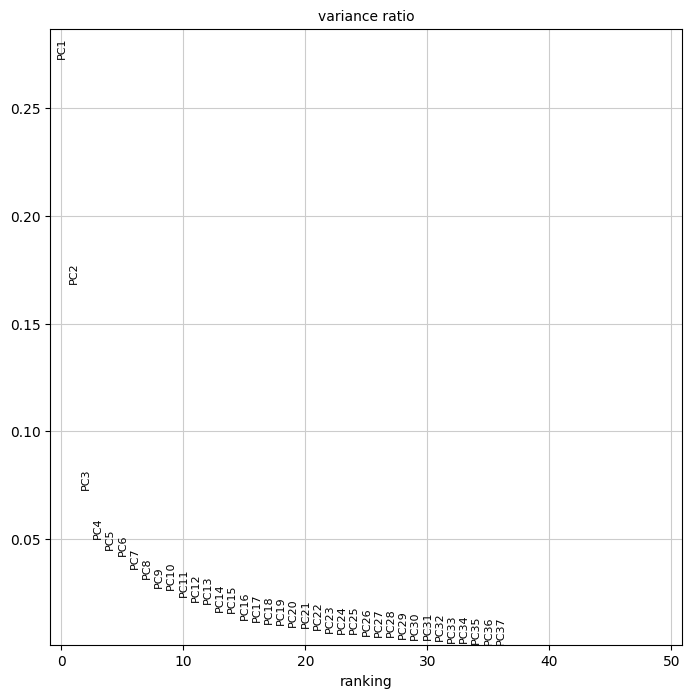

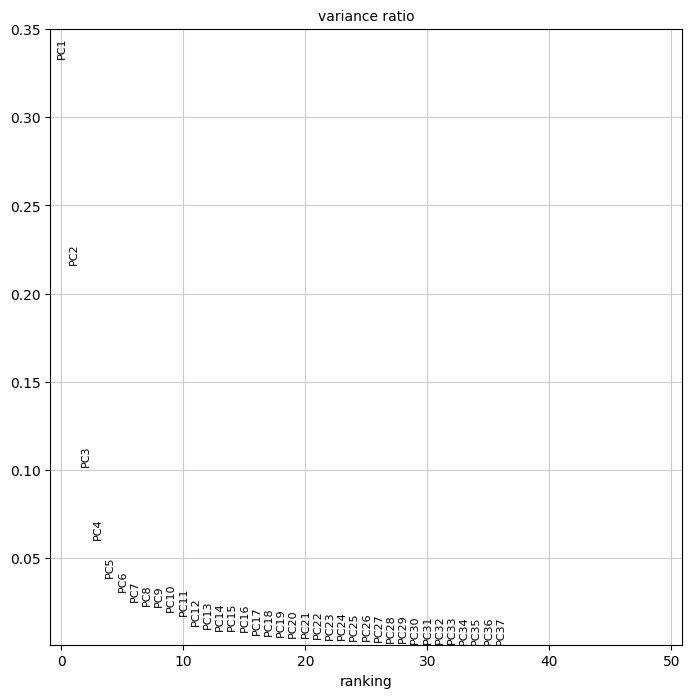

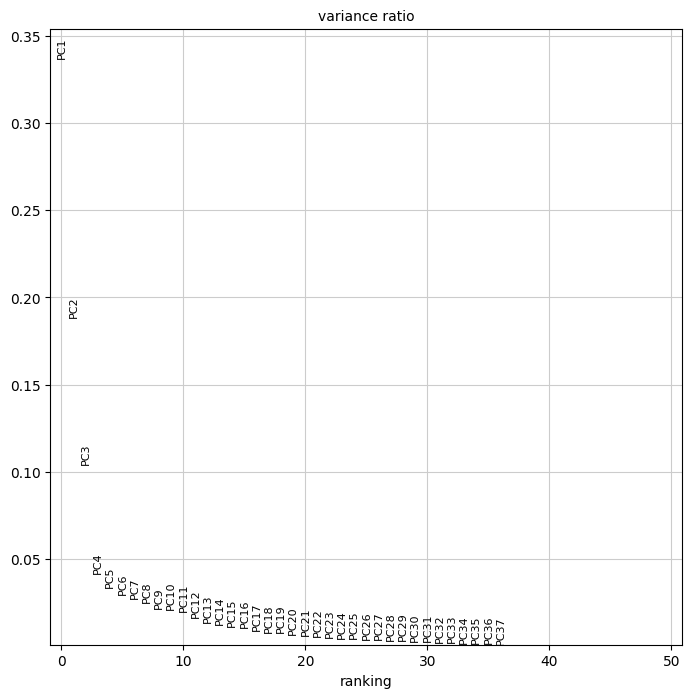

In [9]:
pc(ROI14_adata, ROI15_adata, ROI16_adata)

In [10]:
pc14 = 3
pc15 = 4
pc16 = 4

## UMAP

In [25]:
def umap(data1, pc1, data2, pc2, data3, pc3):
    sc.settings.set_figure_params(dpi=100, fontsize=12,figsize=(10,10))
    
    # Computing the neighborhood graph
    sc.pp.neighbors(data1, n_neighbors=10, n_pcs=pc1)
    sc.tl.umap(data1, random_state=0, min_dist=0.3, spread=1) 
    sc.tl.leiden(data1,resolution=2.2, key_added = "leiden")
         
    sc.pp.neighbors(data2, n_neighbors=10, n_pcs=pc2)
    sc.tl.umap(data2, random_state=0, min_dist=0.2, spread=0.9) 
    sc.tl.leiden(data2,resolution=2.2, key_added = "leiden")
    
    sc.pp.neighbors(data3, n_neighbors=10, n_pcs=pc3)
    sc.tl.umap(data3, random_state=0, min_dist=0.3, spread=1) 
    sc.tl.leiden(data3,resolution=2.2, key_added = "leiden")  
    
        
    
    #plot results
    sc.pl.umap(data1, color ='leiden', s=20, use_raw=False, title = 'ROI14', save=  'ROI14.png')
    sc.pl.umap(data2, color ='leiden', s=20, use_raw=False, title = 'ROI15', save=  'ROI15.png')
    sc.pl.umap(data3, color ='leiden', s=20, use_raw=False, title = 'ROI16', save= 'ROI16.png')

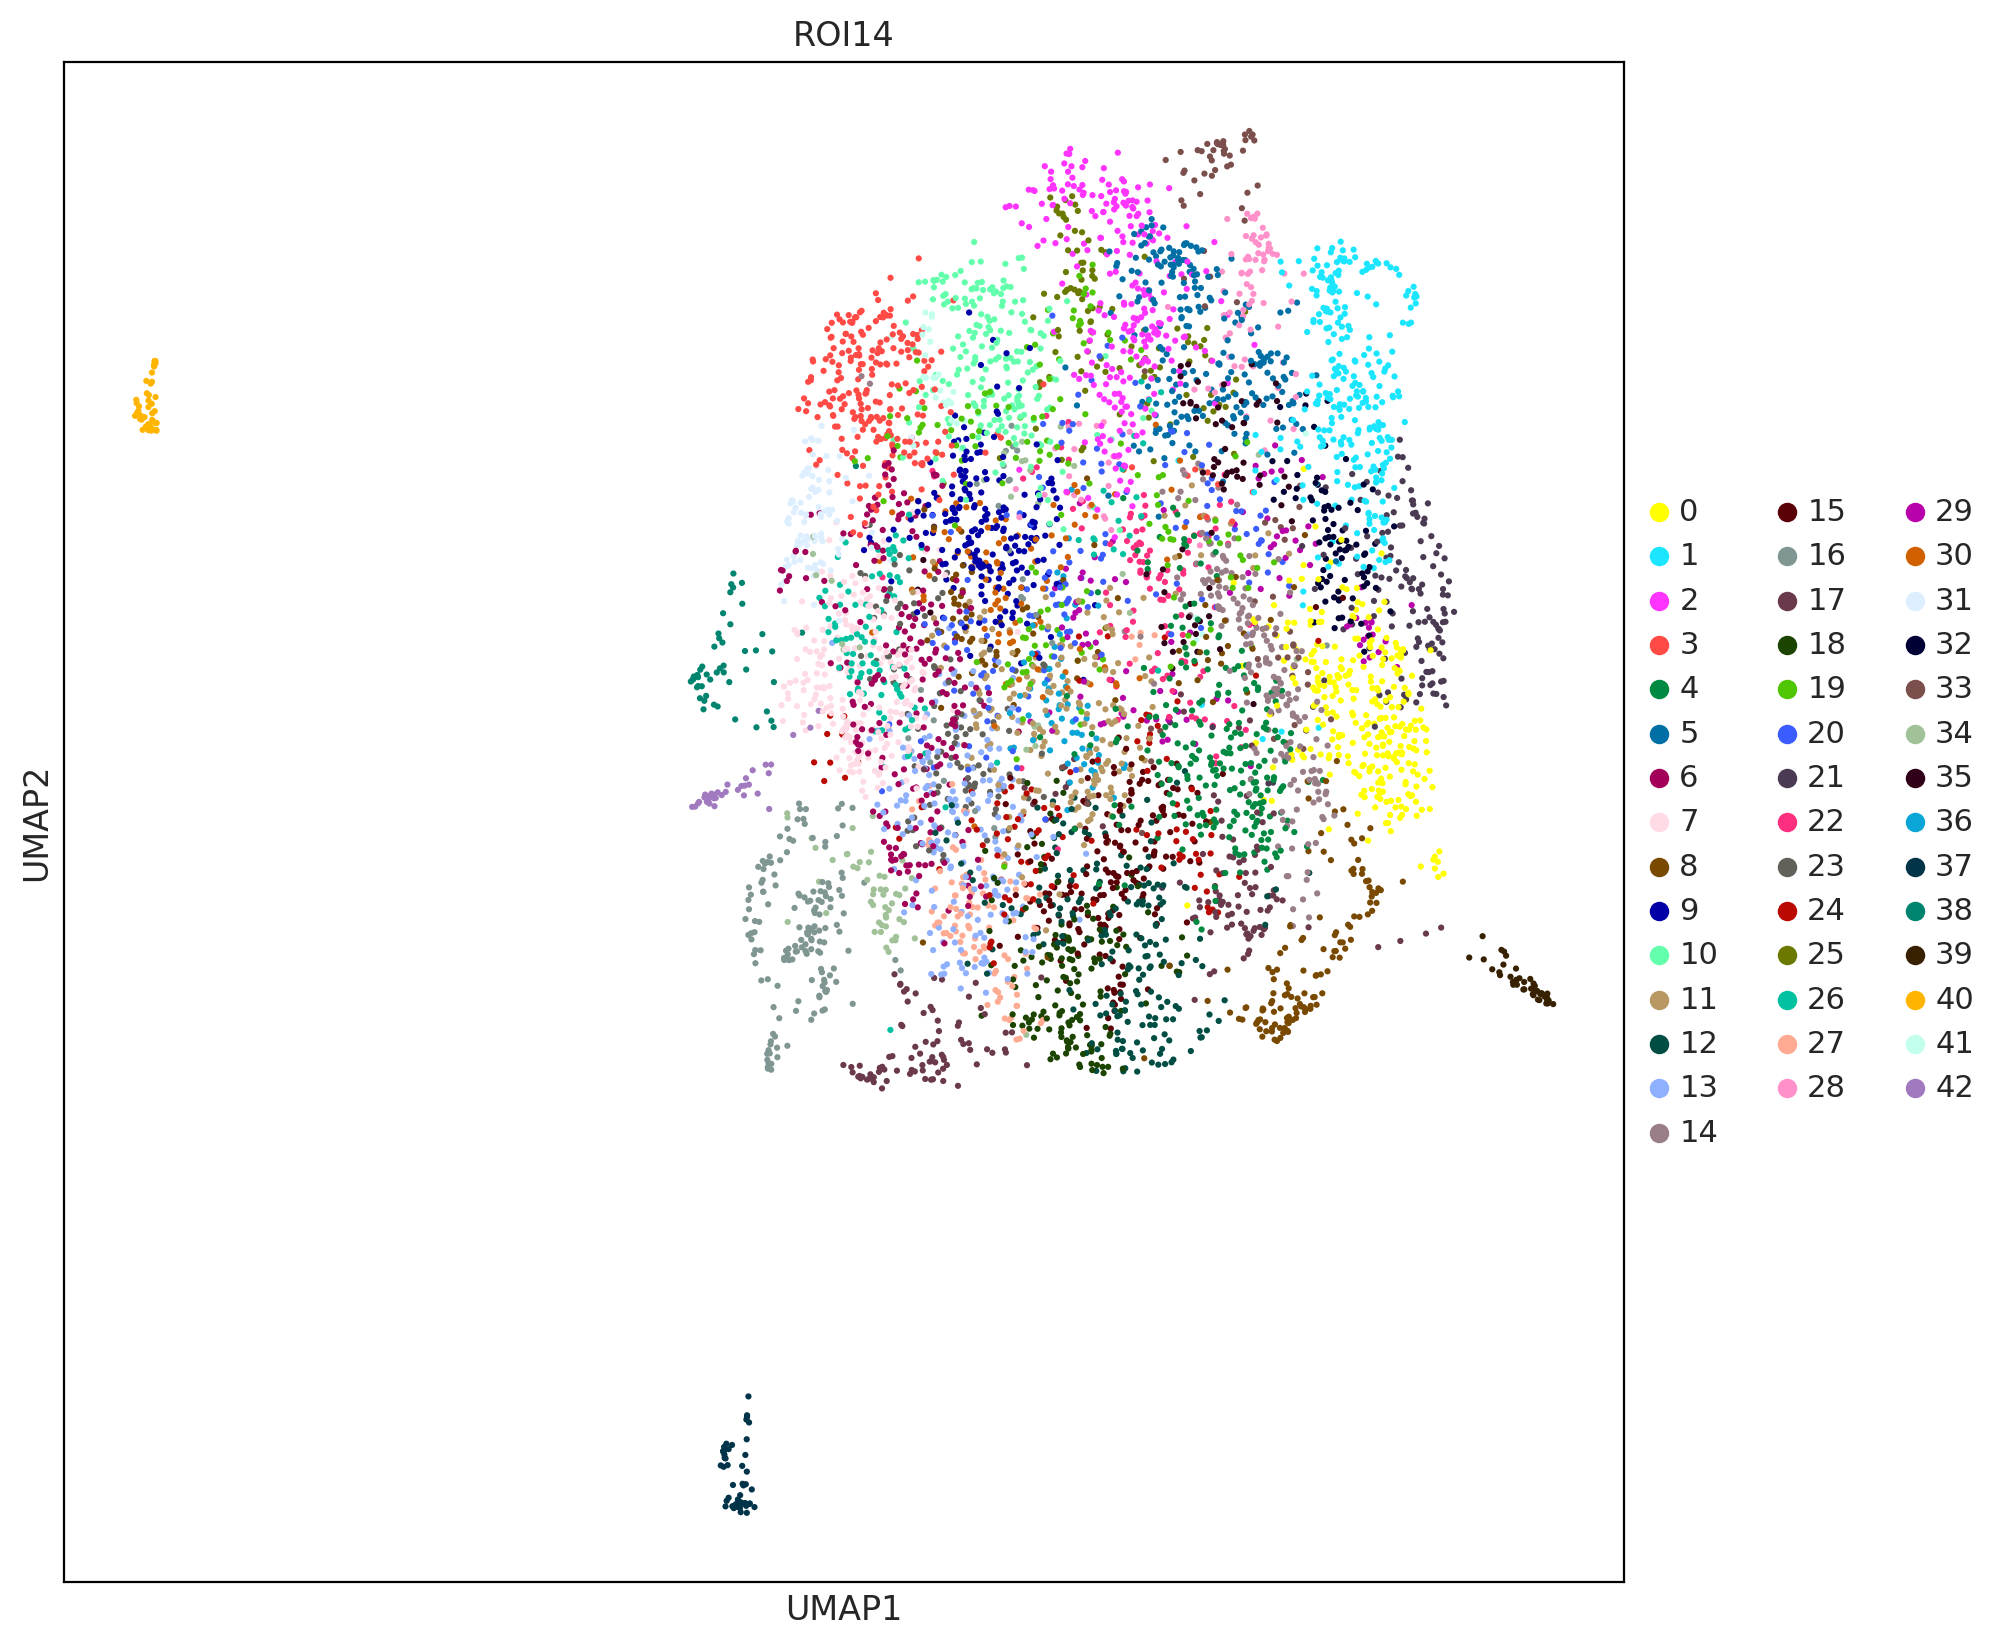

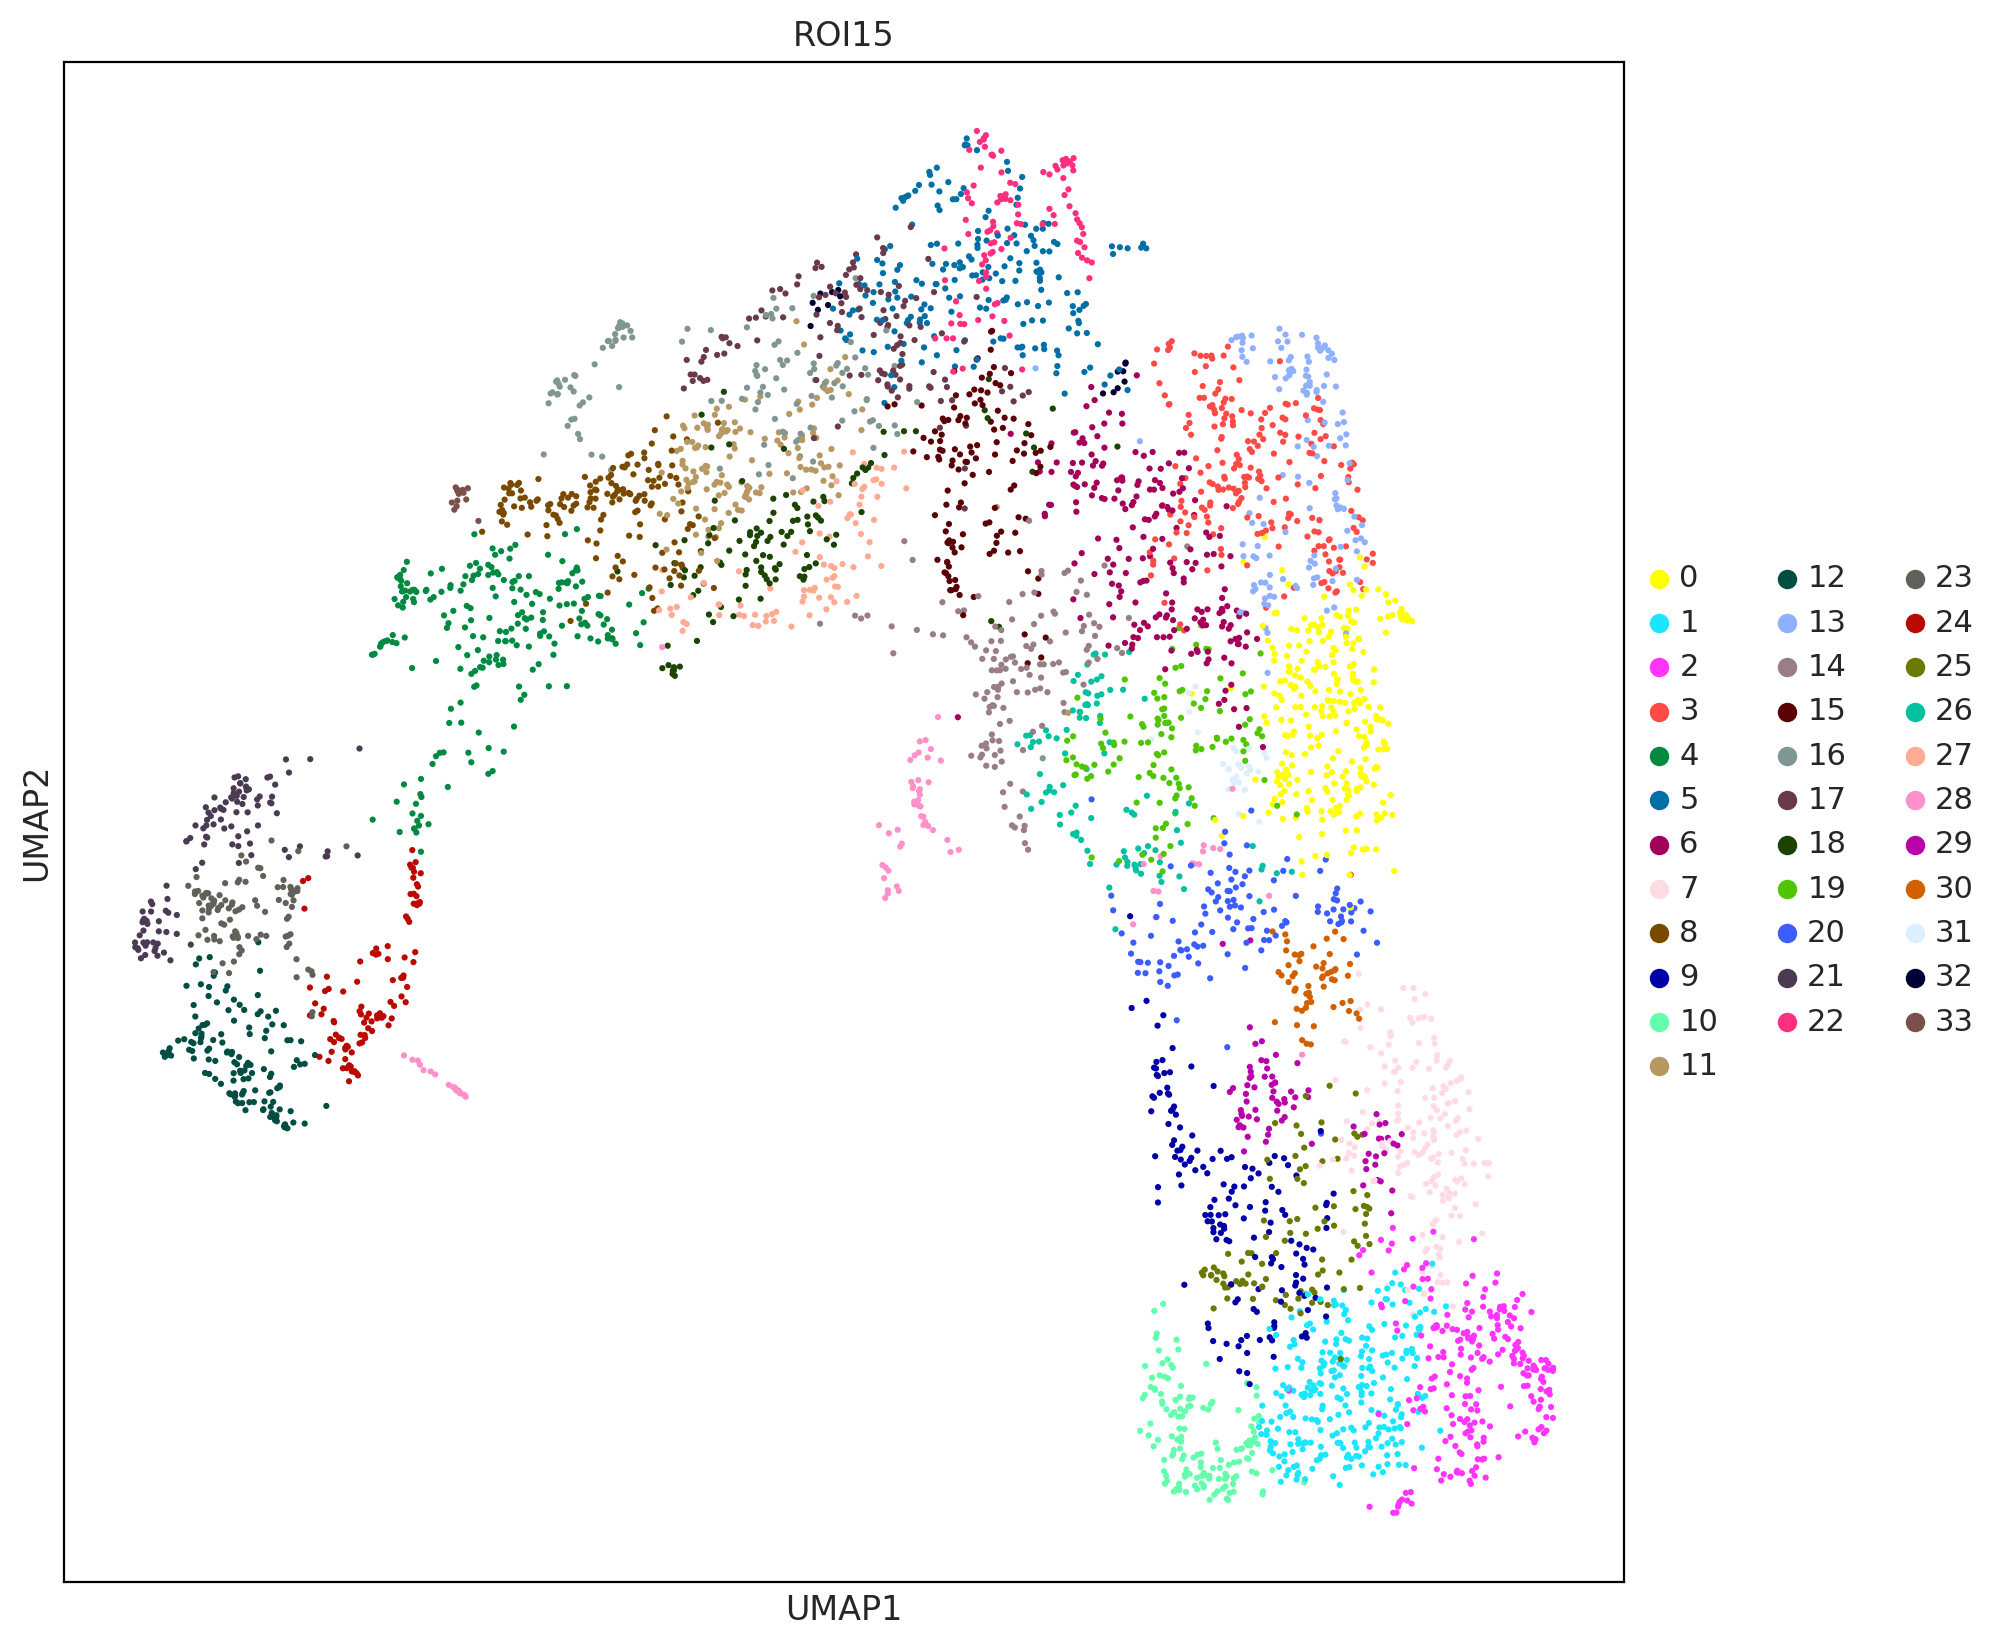

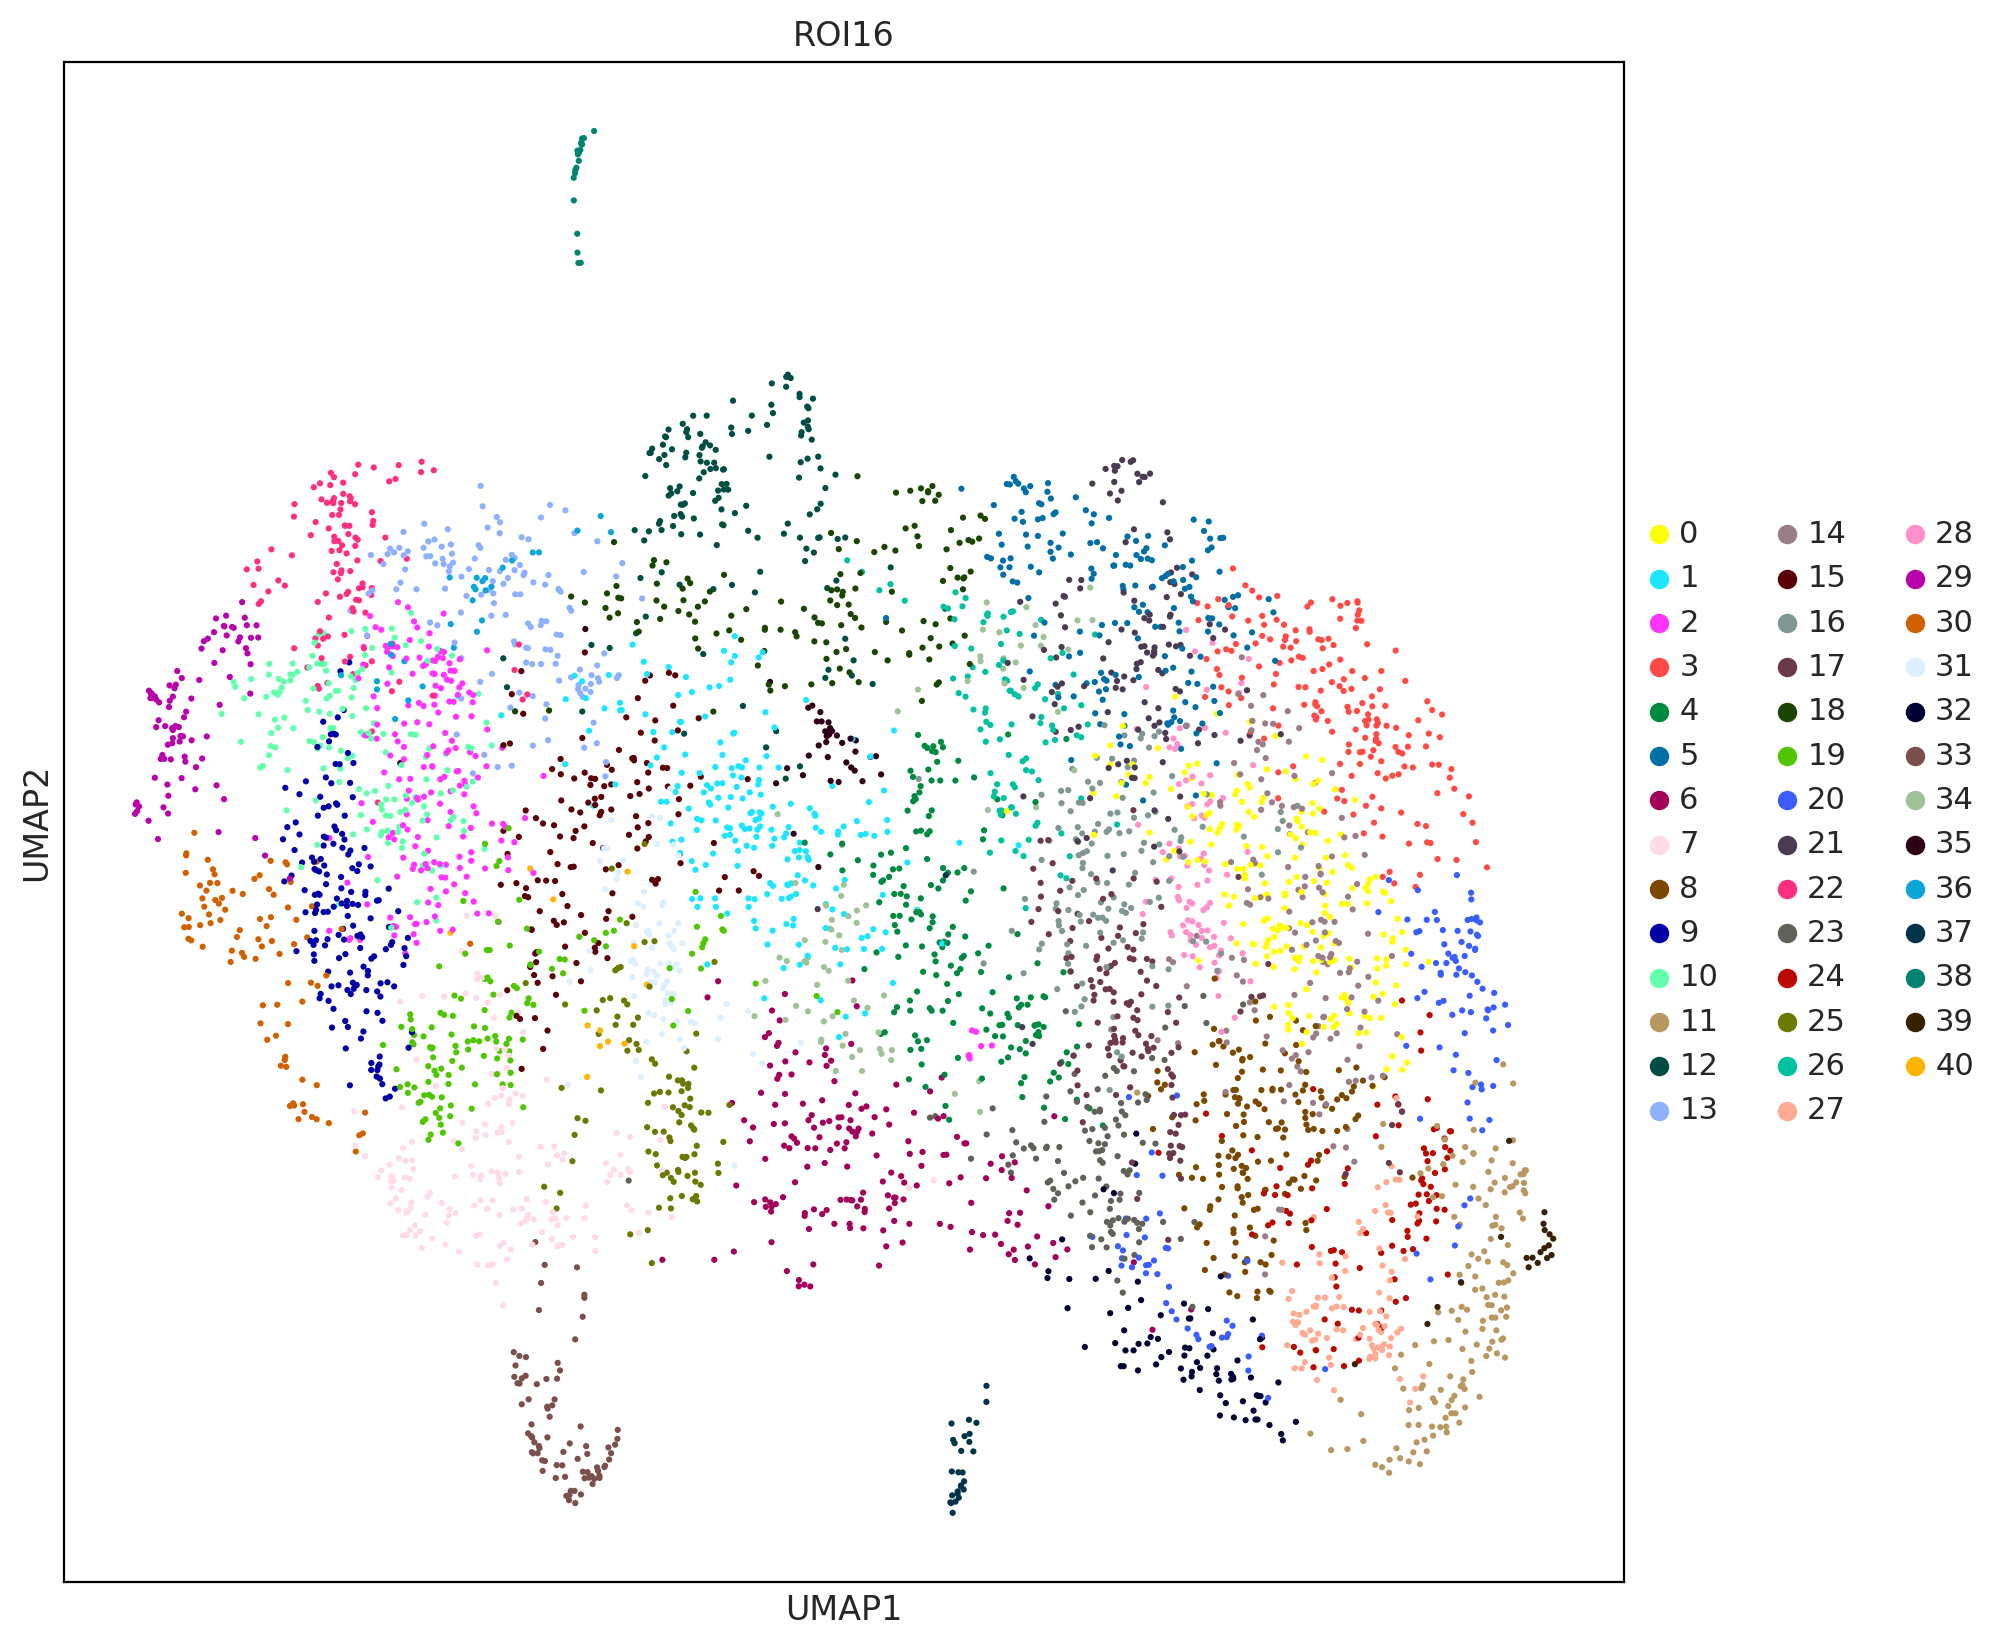

In [26]:
umap(ROI14_adata, pc14, ROI15_adata, pc15, ROI16_adata, pc16)

# Spatial visualisation

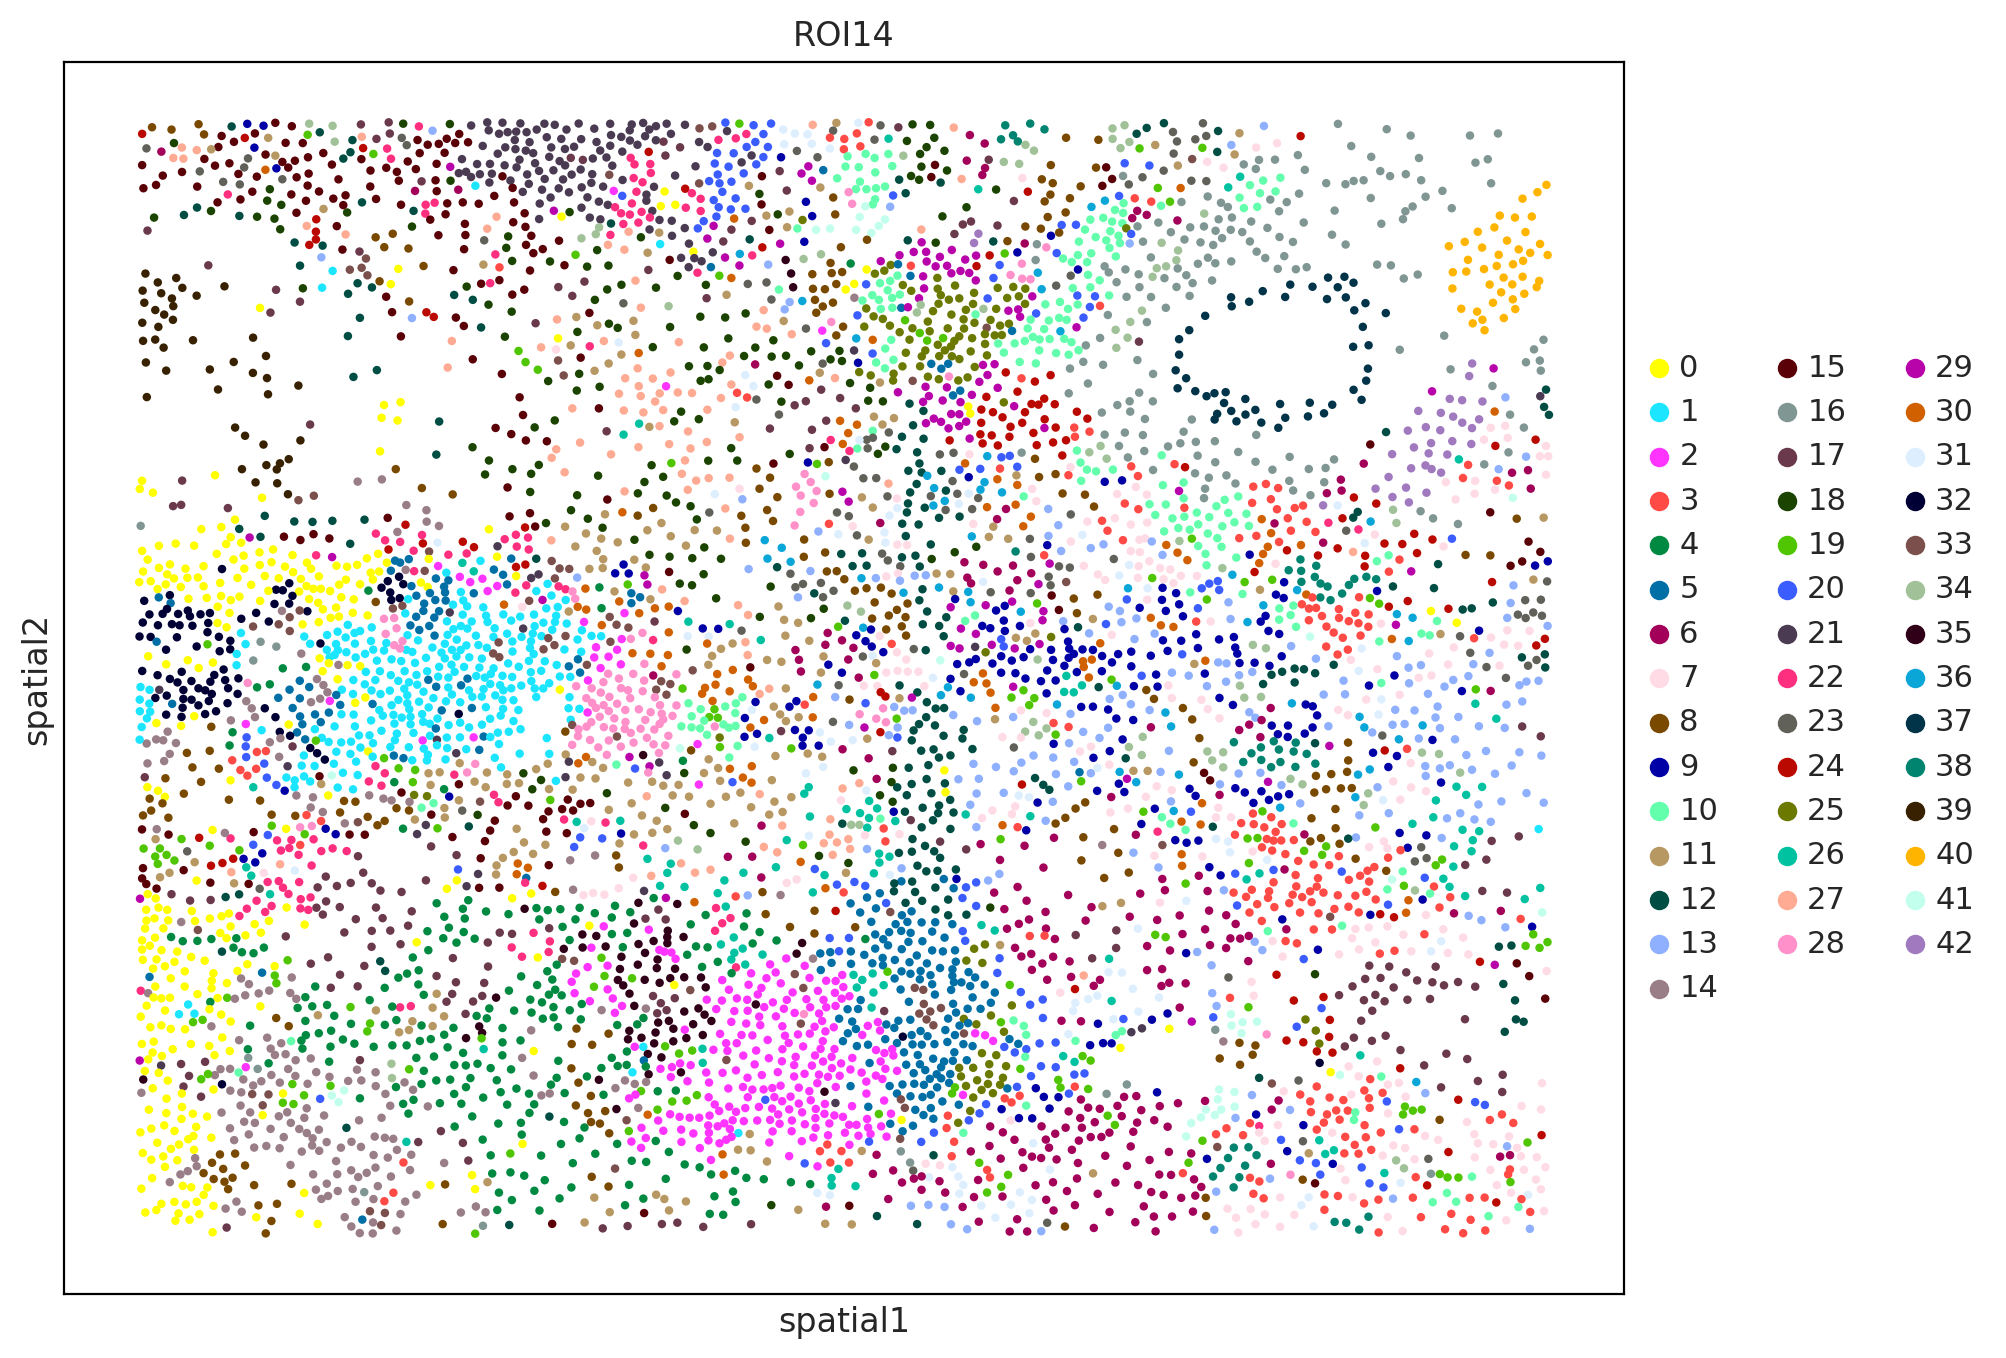

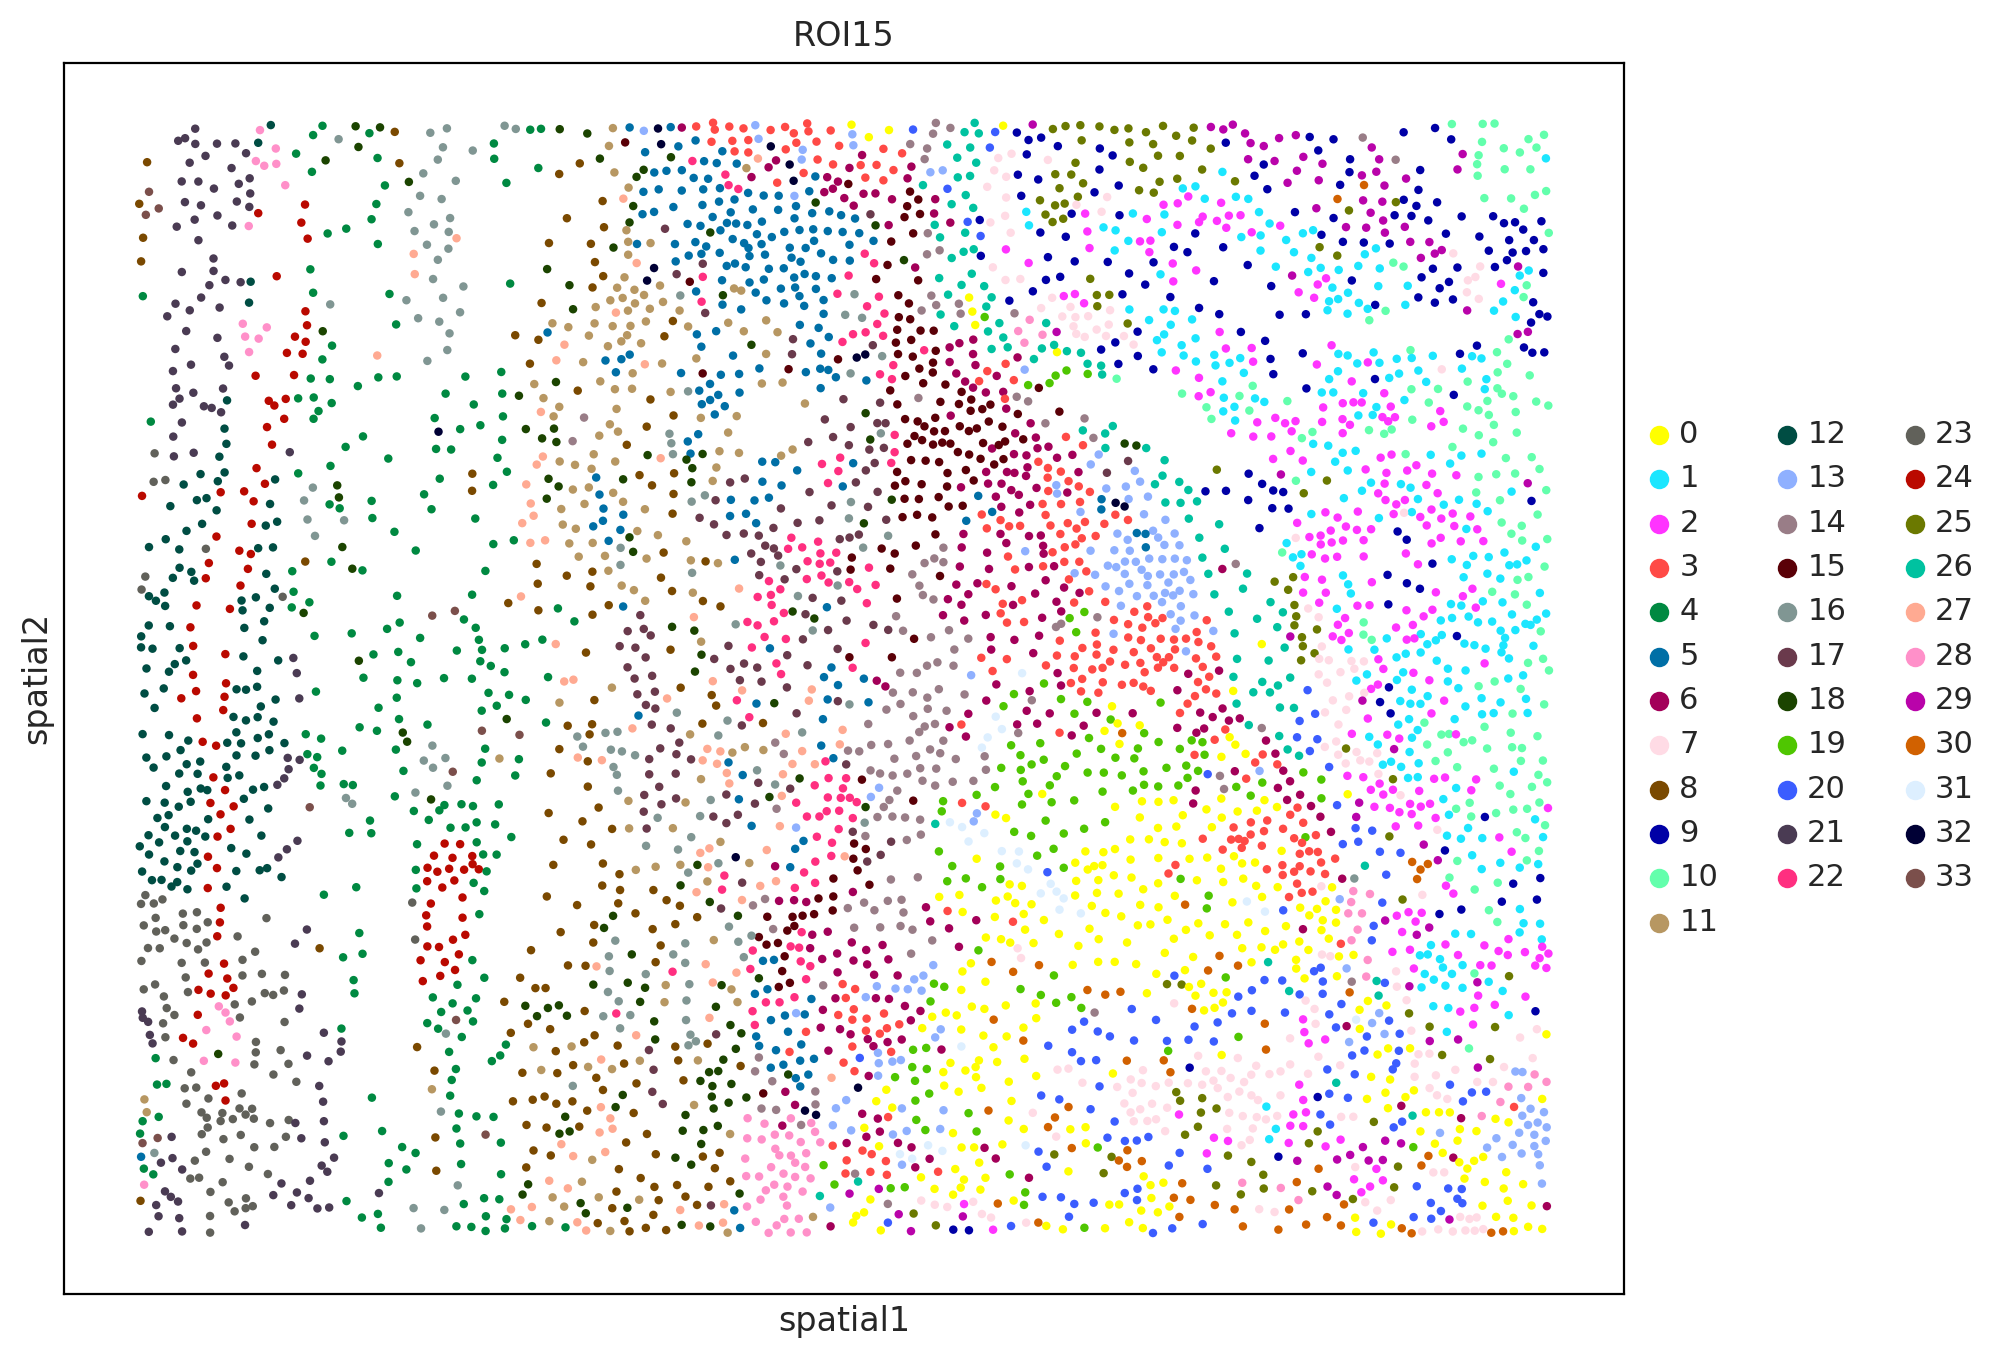

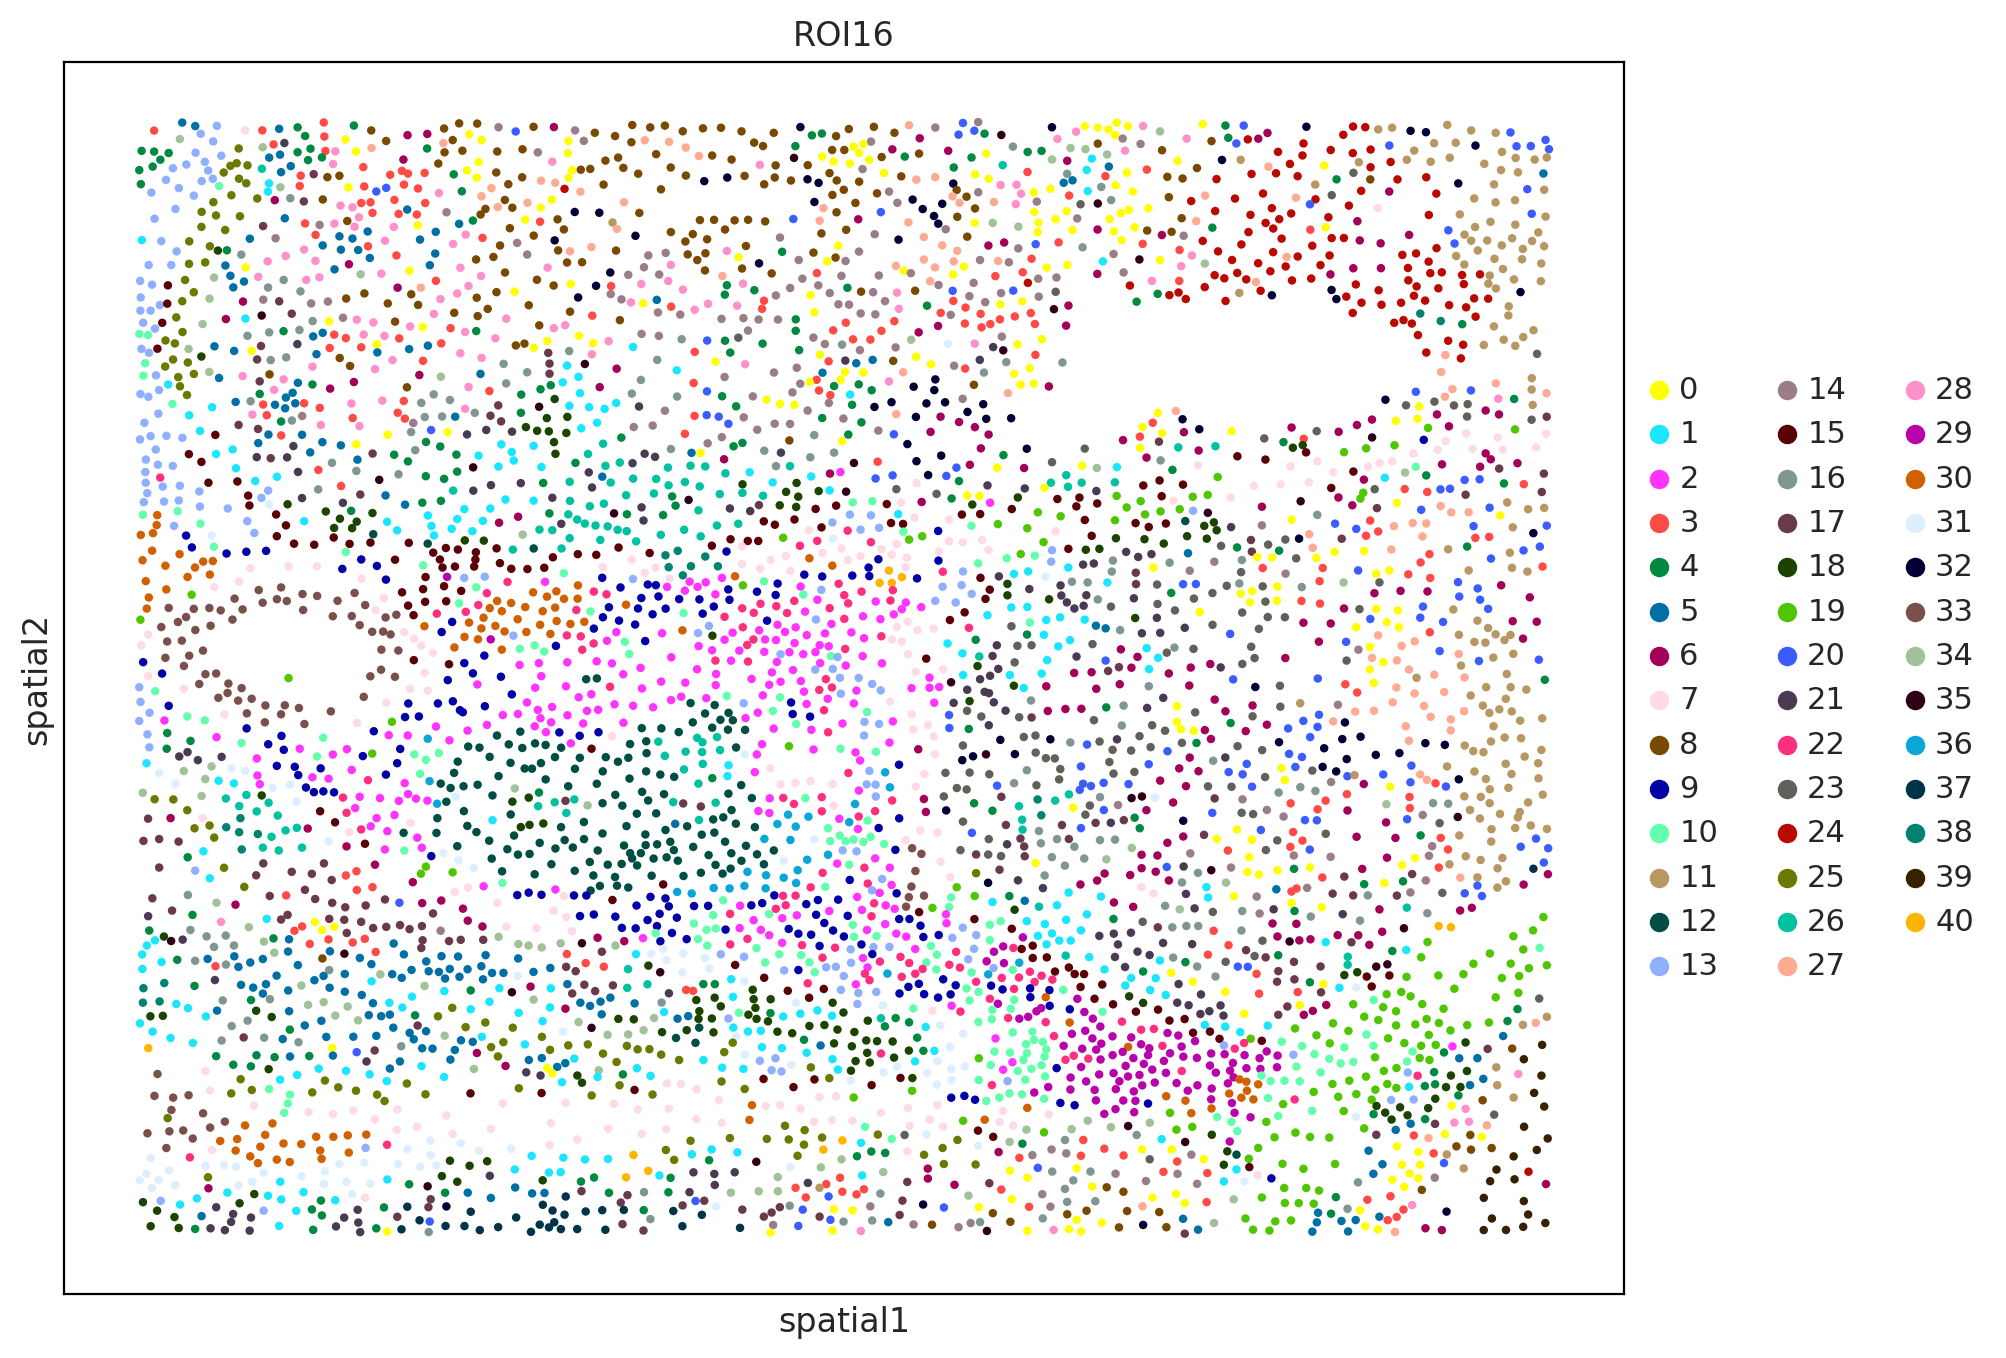

In [27]:
sc.pl.spatial(ROI14_adata, color="leiden", spot_size=55, scale_factor=1, save = 'ROI14_Spatial.png', title = 'ROI14')
sc.pl.spatial(ROI15_adata, color="leiden", spot_size=55, scale_factor=1, save = 'ROI15_Spatial.png', title = 'ROI15')
sc.pl.spatial(ROI16_adata, color="leiden", spot_size=55, scale_factor=1, save = 'ROI16_Spatial.png', title = 'ROI16')

## Matrix plots

In [28]:
# median per cluster for heatmap
def median_cluster(data, numOfCluster, cluster):
    cluster_count = 0
    cluster_df = pd.DataFrame(columns=data.columns.to_list())

    while cluster_count < numOfCluster:
        id_of_cluster = [key for key, val in cluster.items() if val == str(cluster_count)] # get all IDs of one cluster
        df_of_cluster = data.loc[id_of_cluster] # generate a dataframe with only the IDs of one cluster 
        median_of_cluster = df_of_cluster.median().to_frame().T # compute the median per marker (column)
        cluster_df = pd.concat([cluster_df, median_of_cluster]) # merge the median results in a dataframe
        cluster_count += 1
    
    cluster_df = cluster_df.reset_index()
    cluster_df = cluster_df.drop('index', axis=1)

    return cluster_df

In [39]:
ROI14 = median_cluster(ROI14_adata.to_df(), 43, ROI14_adata.obs['leiden'])
ROI15 = median_cluster(ROI15_adata.to_df(), 34, ROI15_adata.obs['leiden'])
ROI16 = median_cluster(ROI16_adata.to_df(), 41, ROI16_adata.obs['leiden'])

In [40]:
# Heatmap: standard-scale, Dendrogram on Cluster
sns.set(font_scale=0.8)
def plotHeatmapDendro1(data, name):
    plot= sns.clustermap(data.T,
                         standard_scale=1,  # Either 0 (rows) or 1 (columns).
                         cmap='Reds', 
                         yticklabels=True, xticklabels=True,
                         figsize=(10, 10),
                         row_cluster=False,
                         col_cluster=True)
    plot.fig.suptitle(name) 
    plot = plt.savefig('results/matrixplot_dendro1_' + name + '.png', dpi=150);

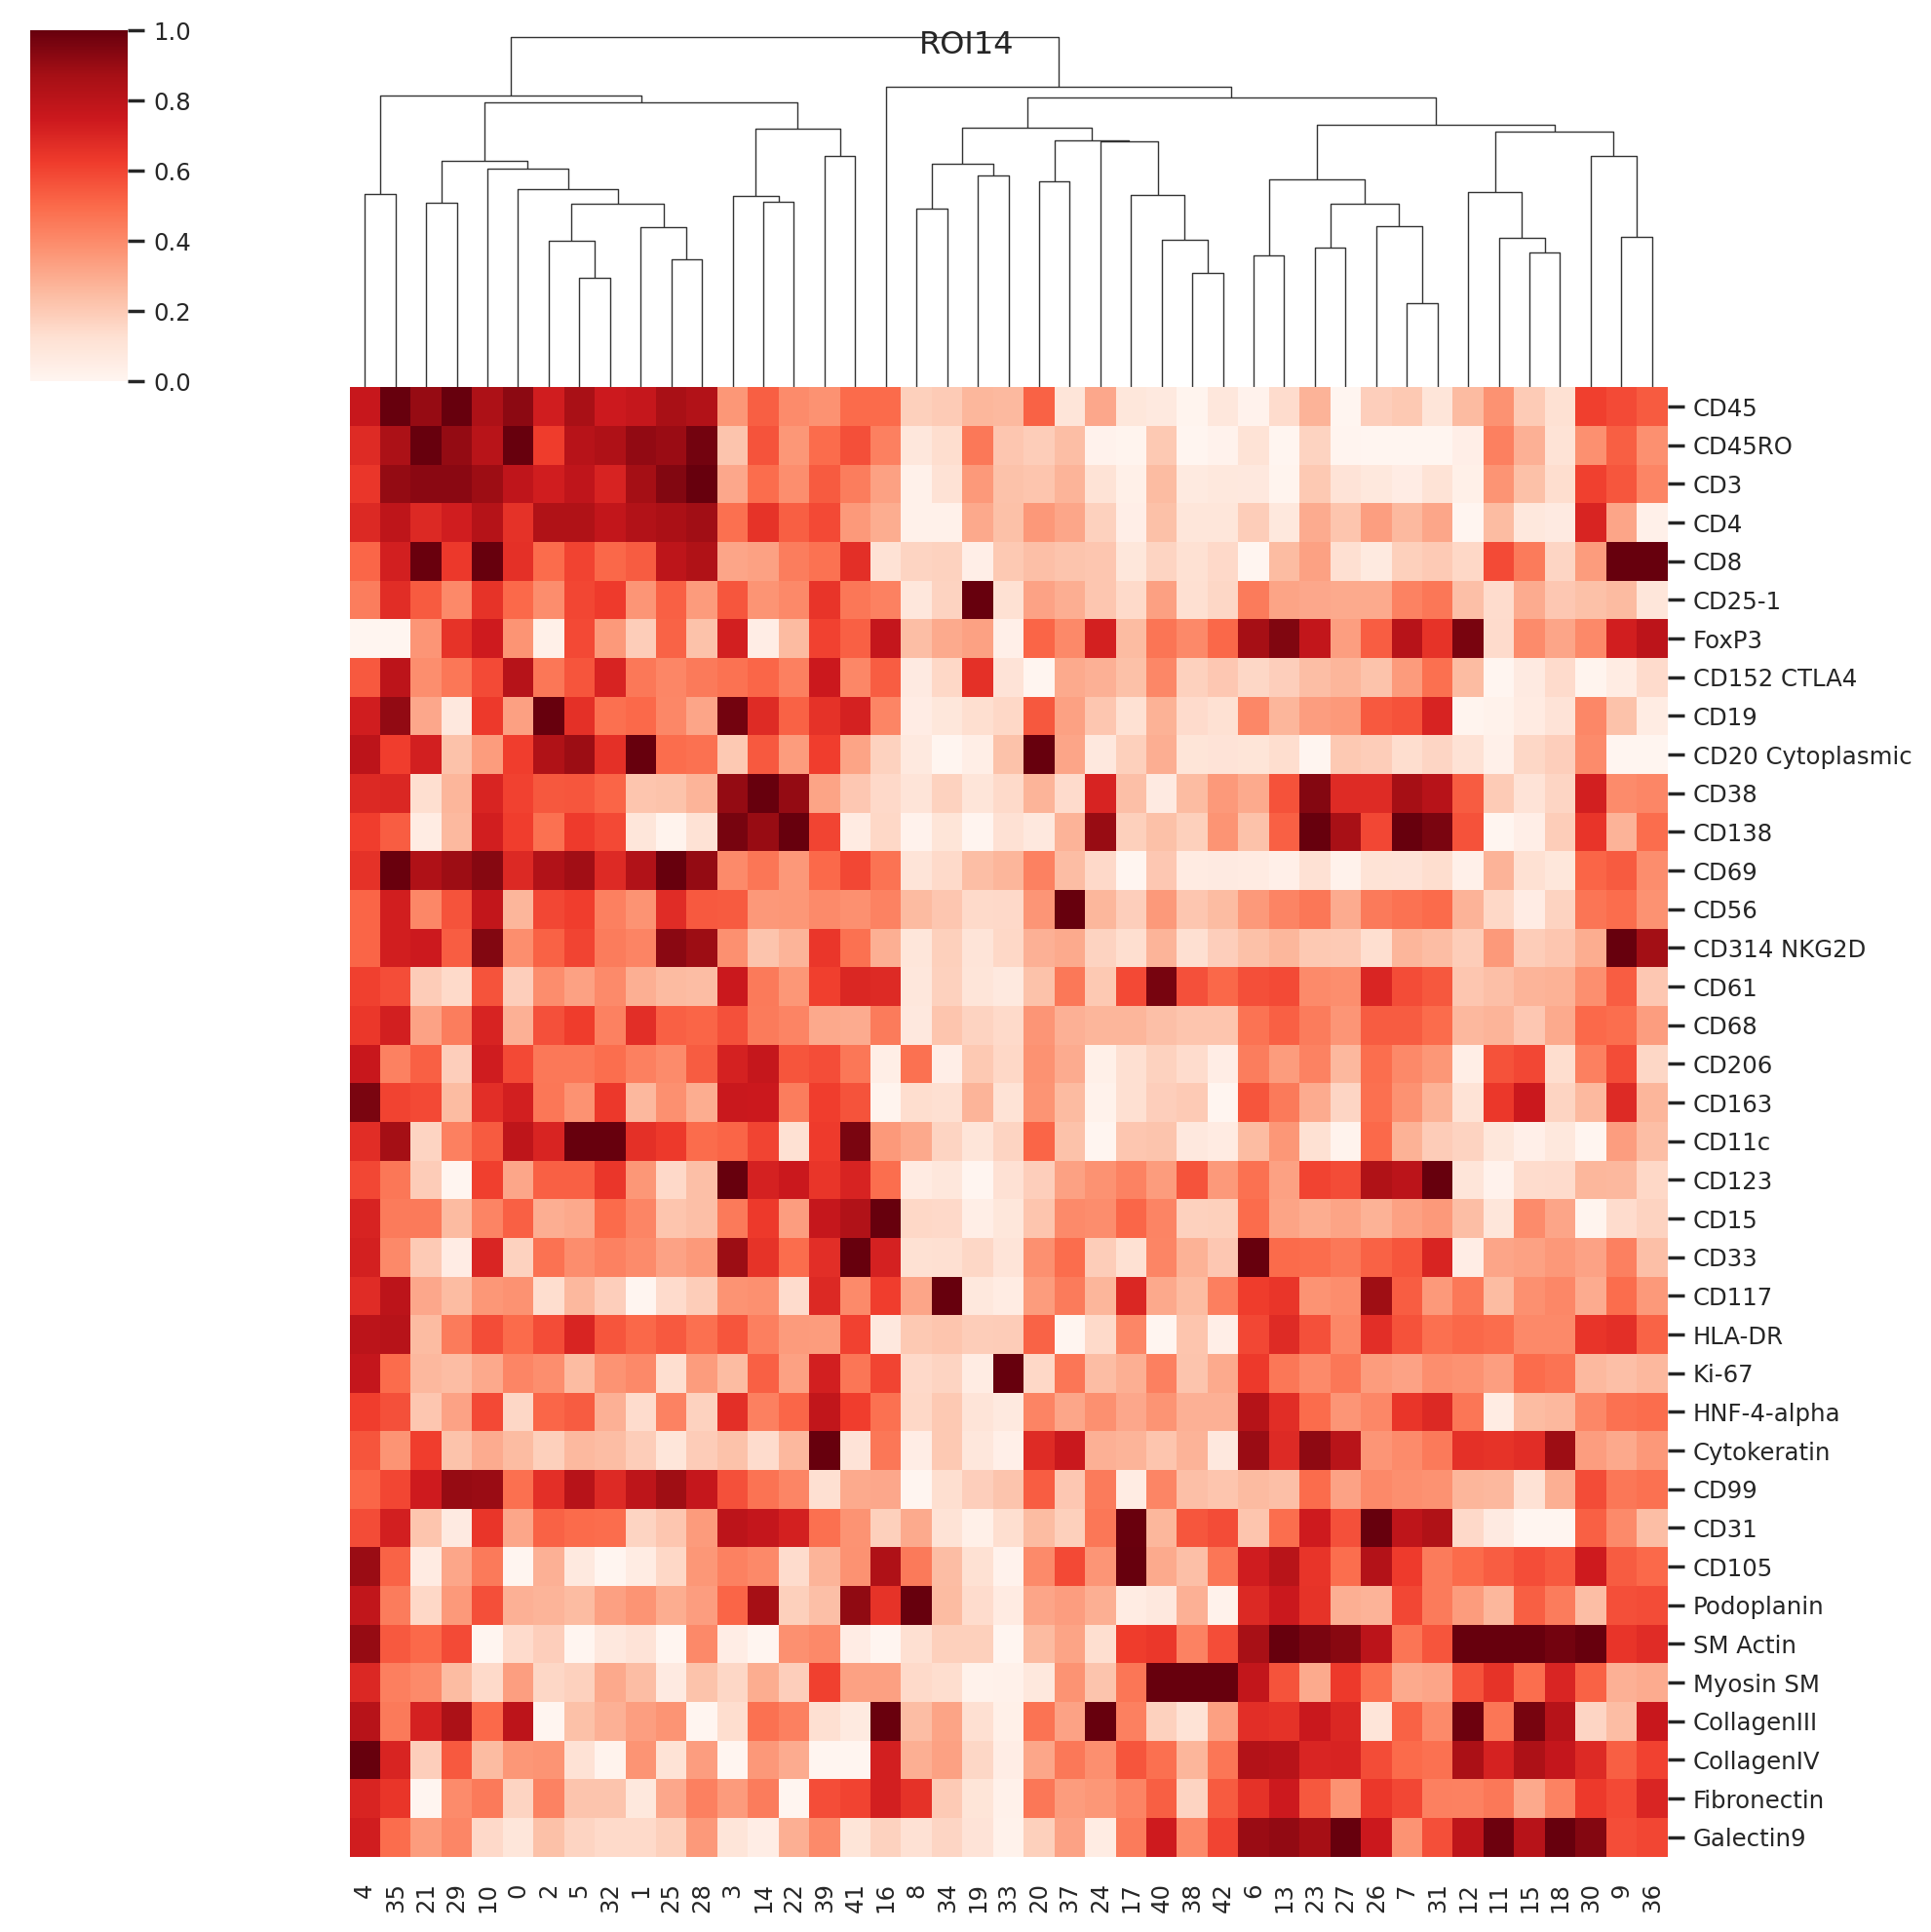

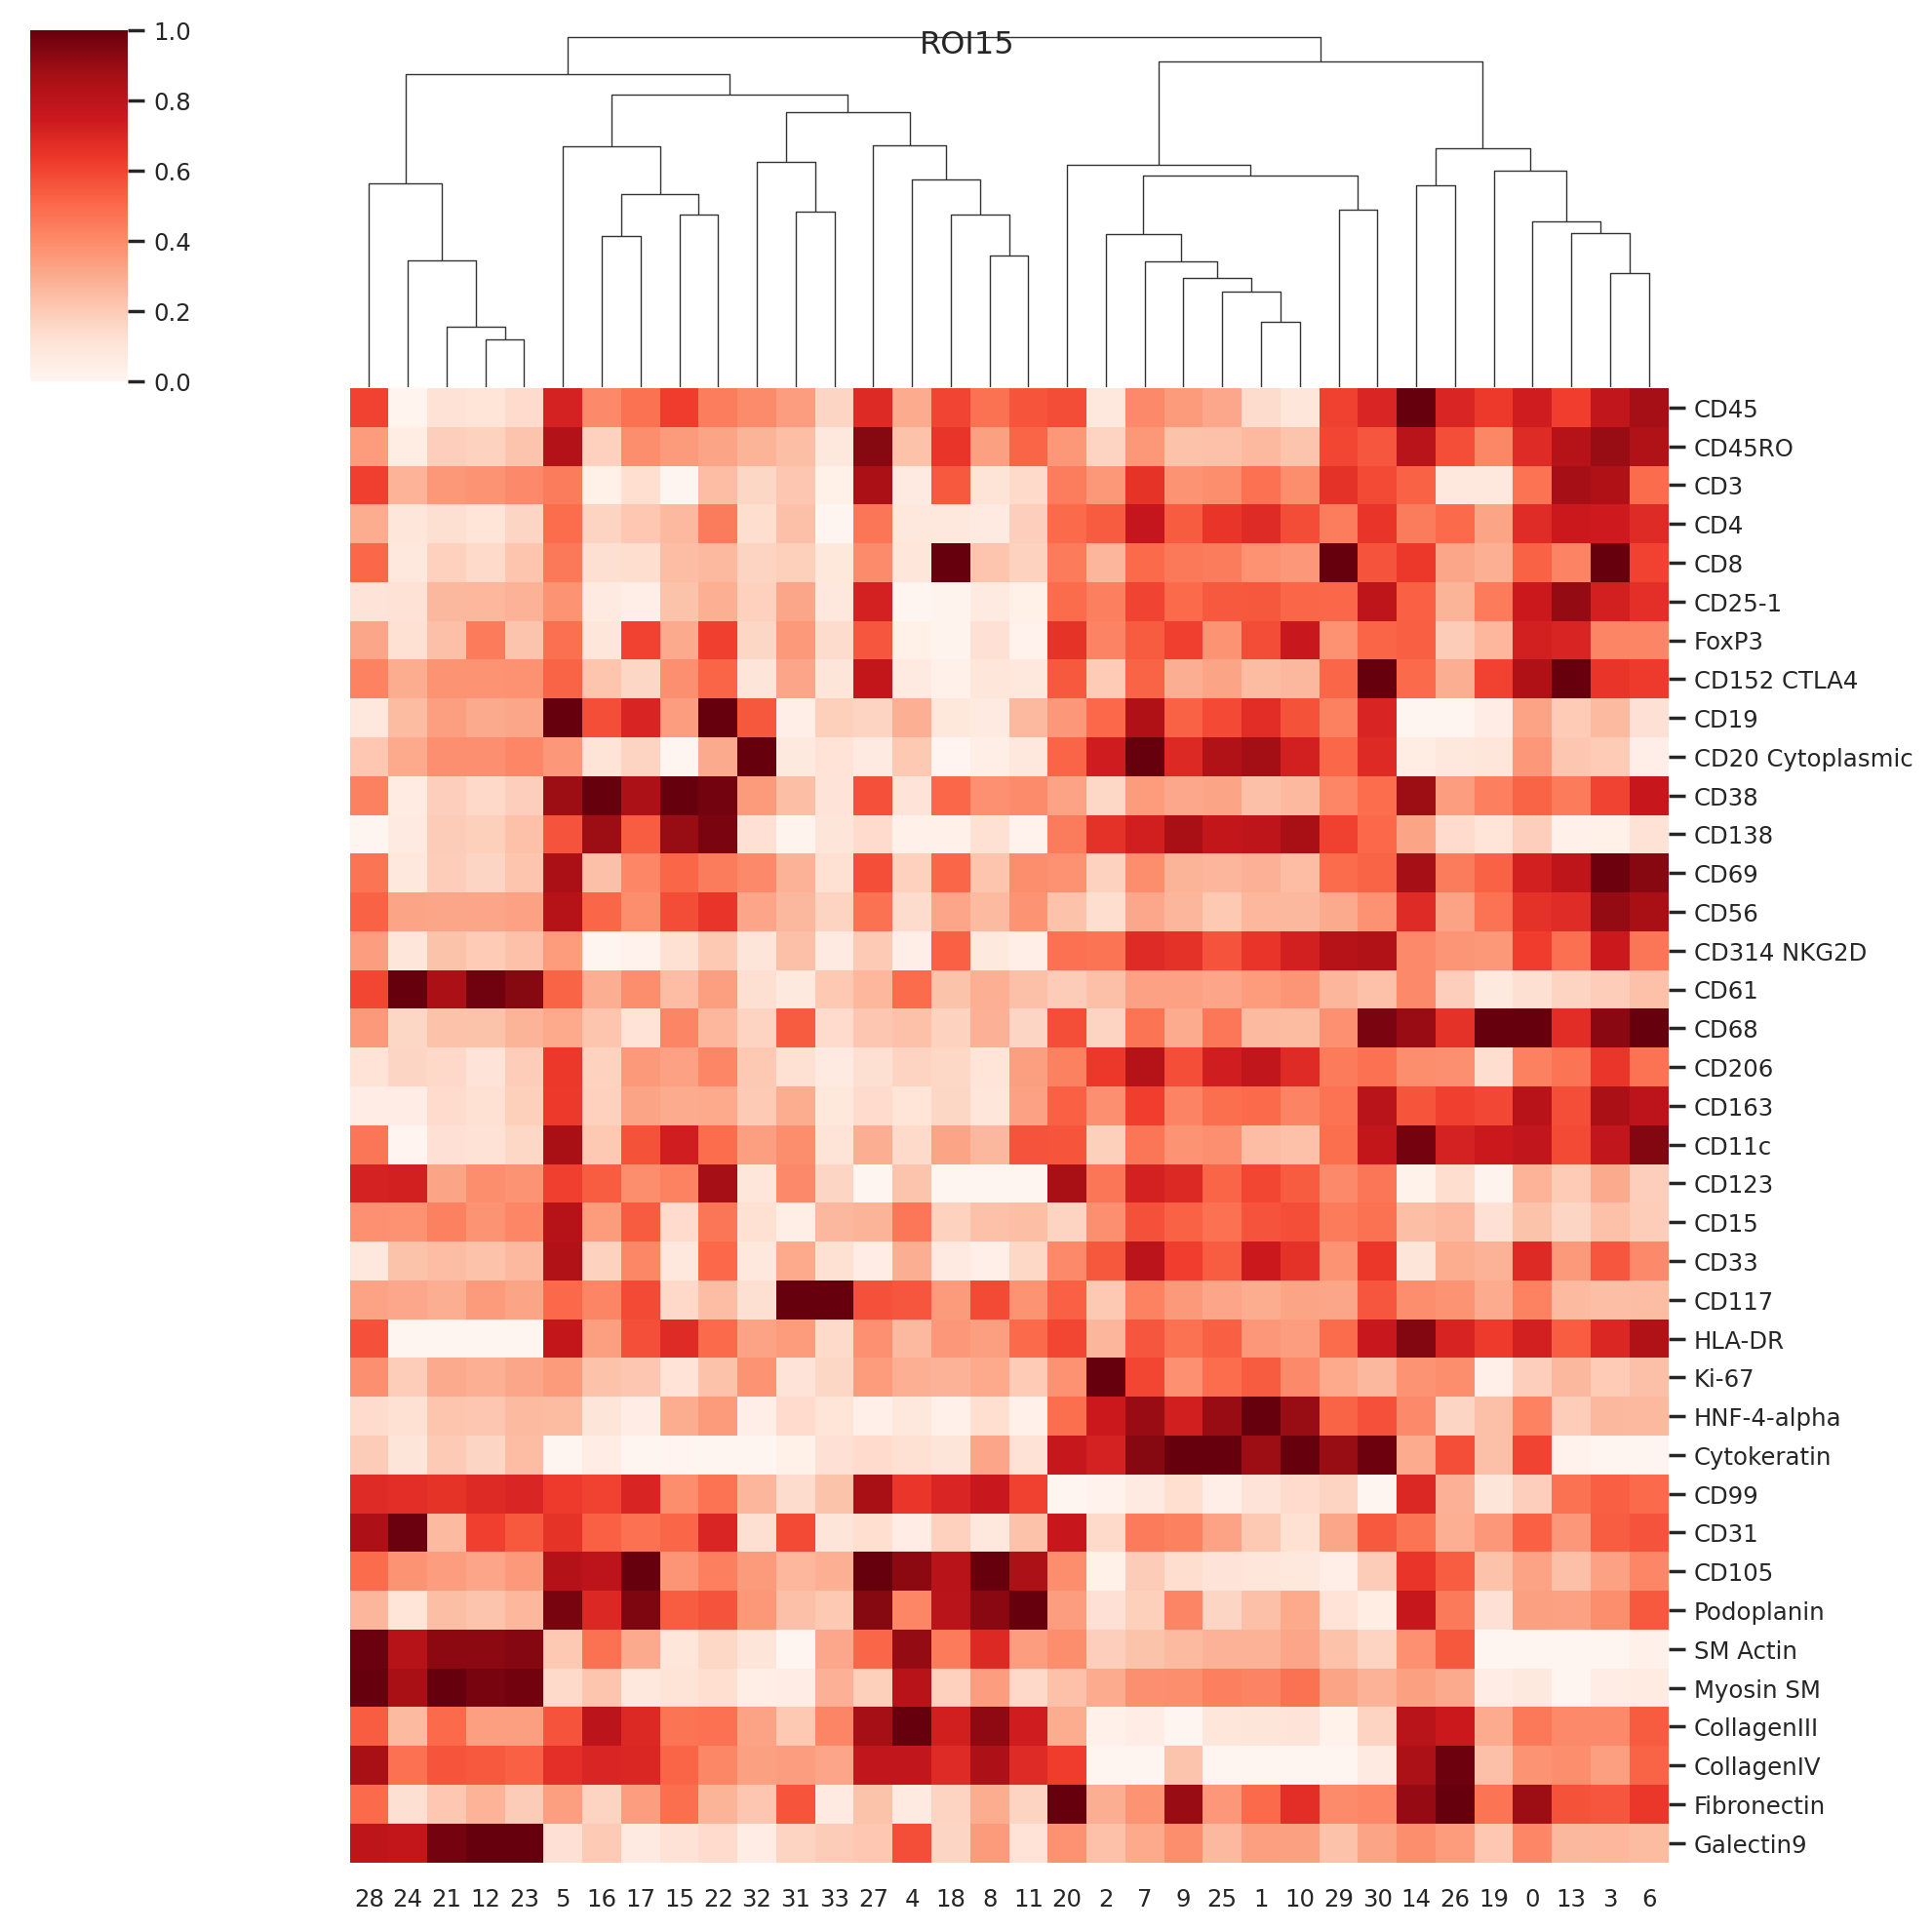

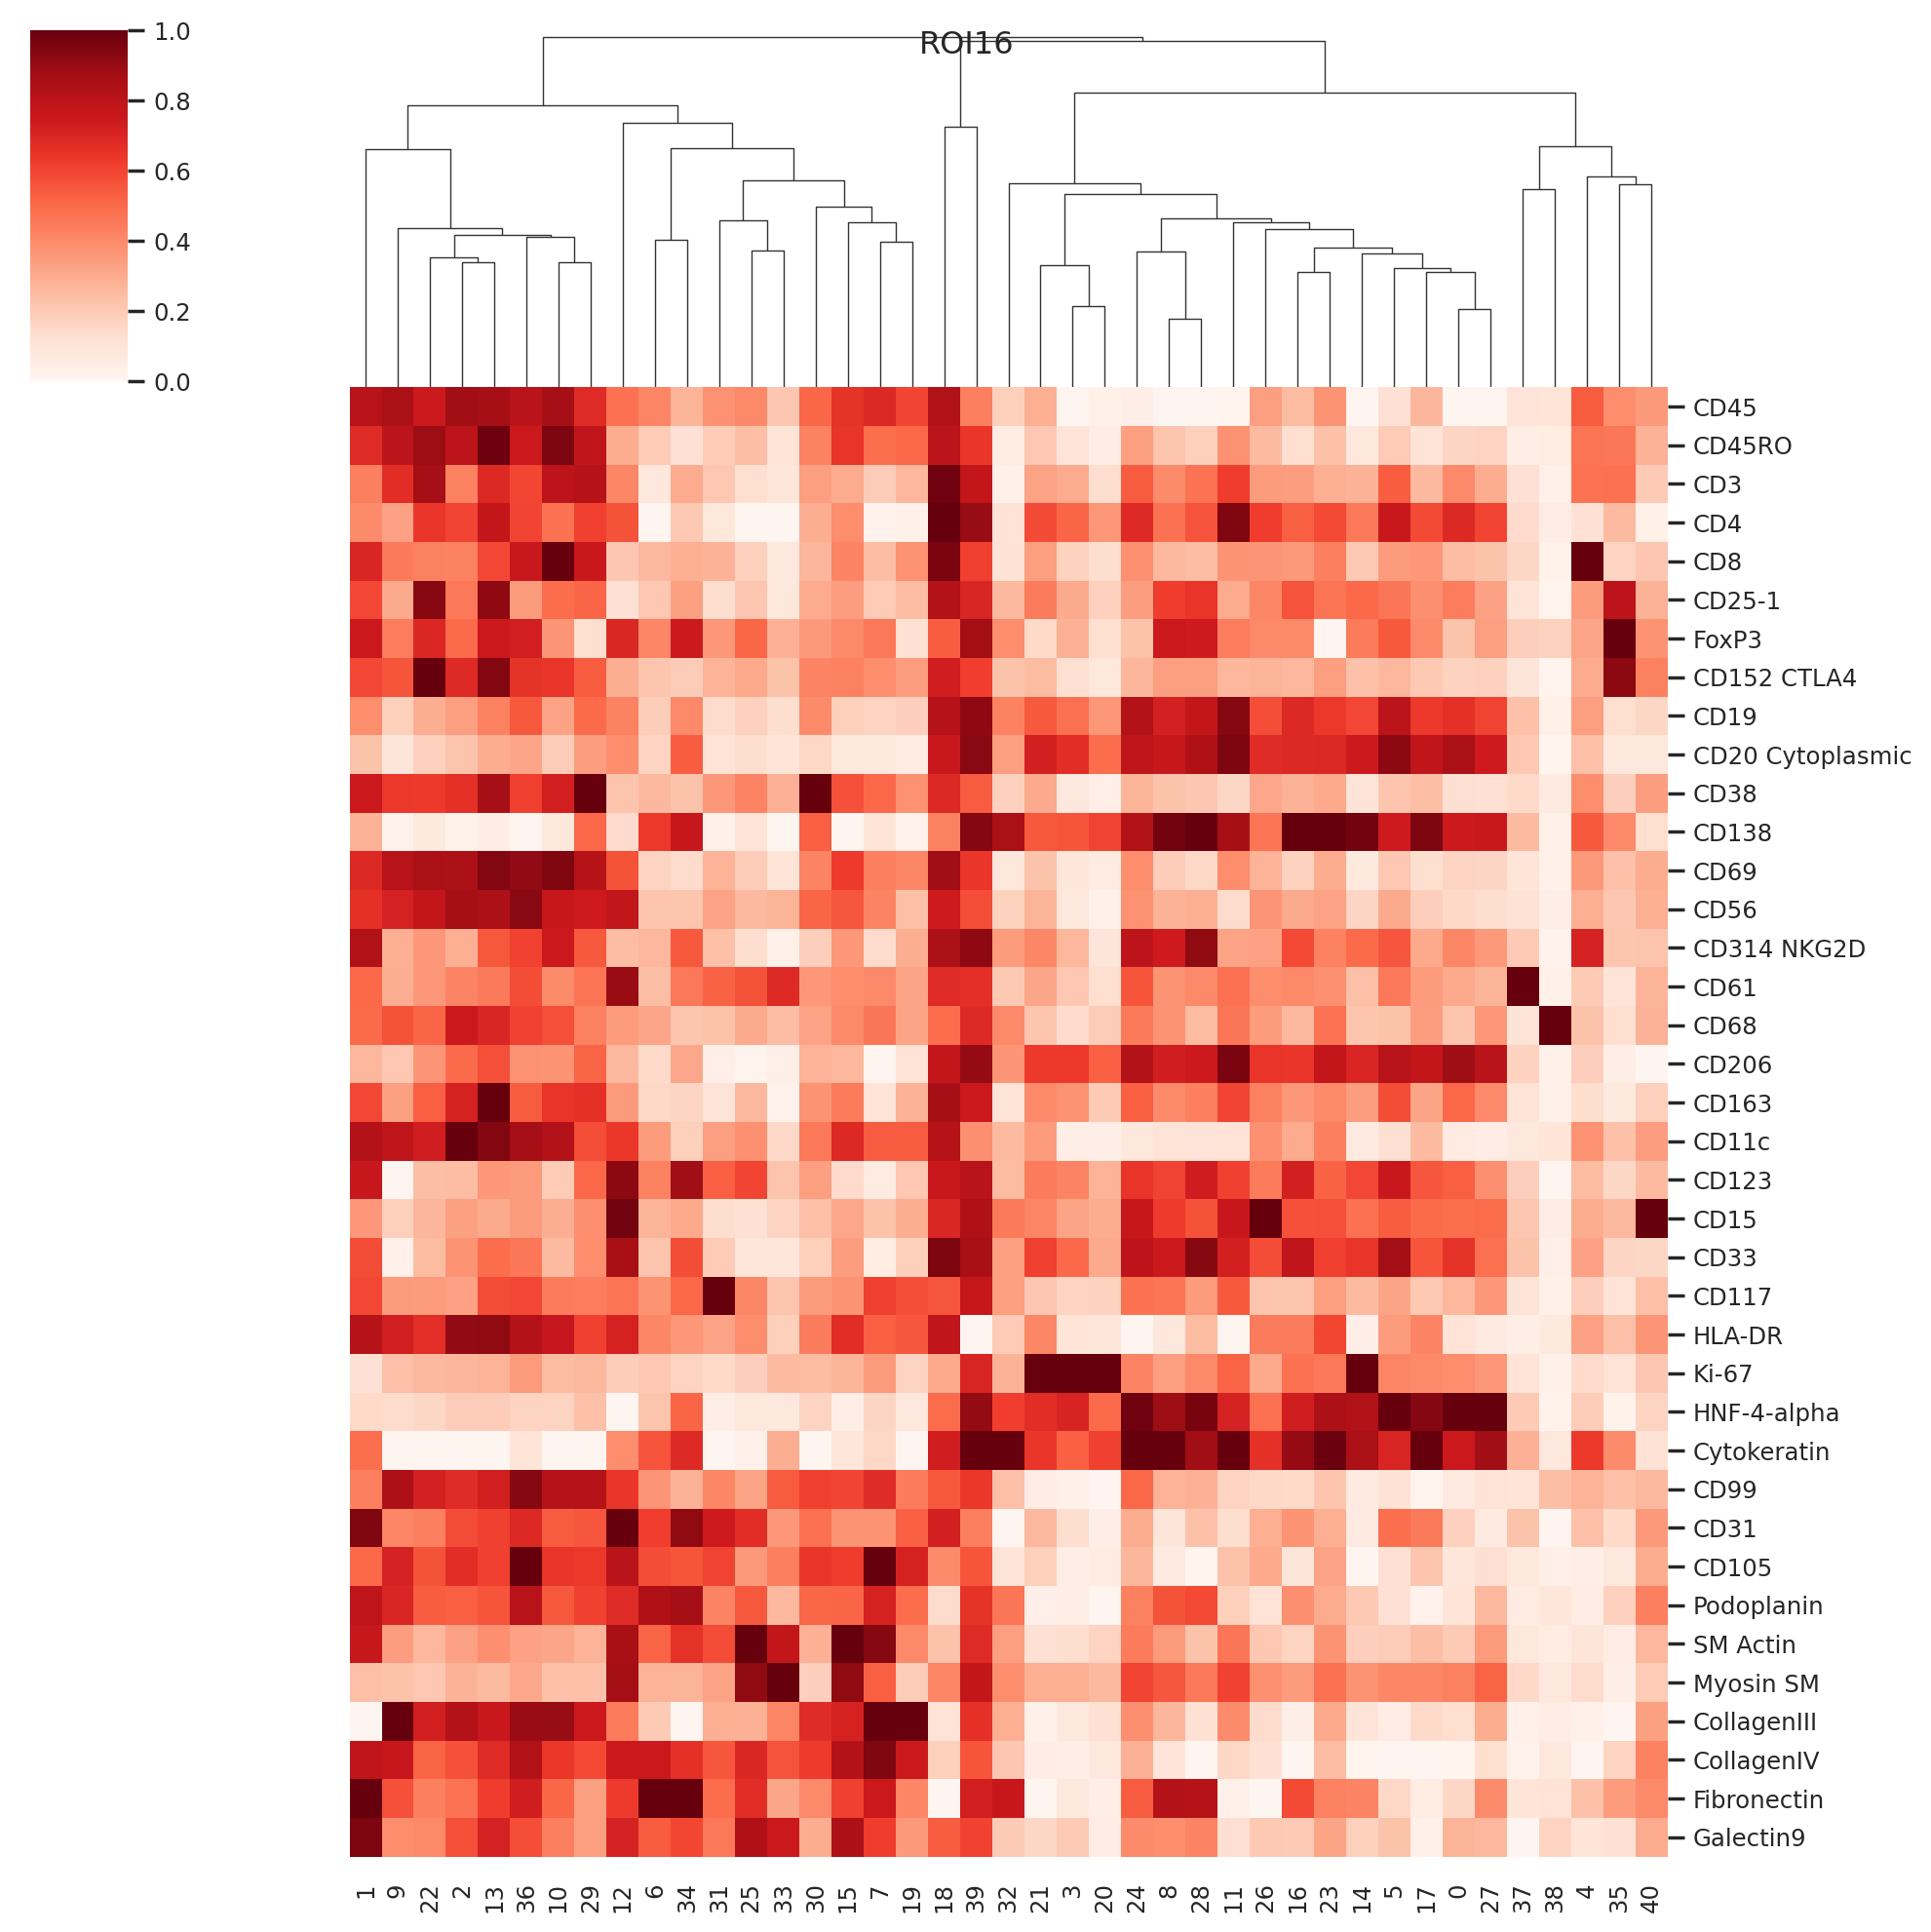

In [41]:
plotHeatmapDendro1(ROI14, 'ROI14')
plotHeatmapDendro1(ROI15, 'ROI15')
plotHeatmapDendro1(ROI16, 'ROI16')

In [42]:
# Heatmap: standard-scale, Dendrogram on Cluster & Marker
sns.set(font_scale=0.8)
def plotHeatmapDendro2(data, name):
    plot= sns.clustermap(data.T,
                         standard_scale=1,  # Either 0 (rows) or 1 (columns).
                         cmap='Reds', 
                         yticklabels=True, xticklabels=True,
                         figsize=(10, 10),
                         row_cluster=True,
                         col_cluster=True)
    plot.fig.suptitle(name) 
    plot = plt.savefig('results/matrixplot_dendro2_' + name + '.png', dpi=150);

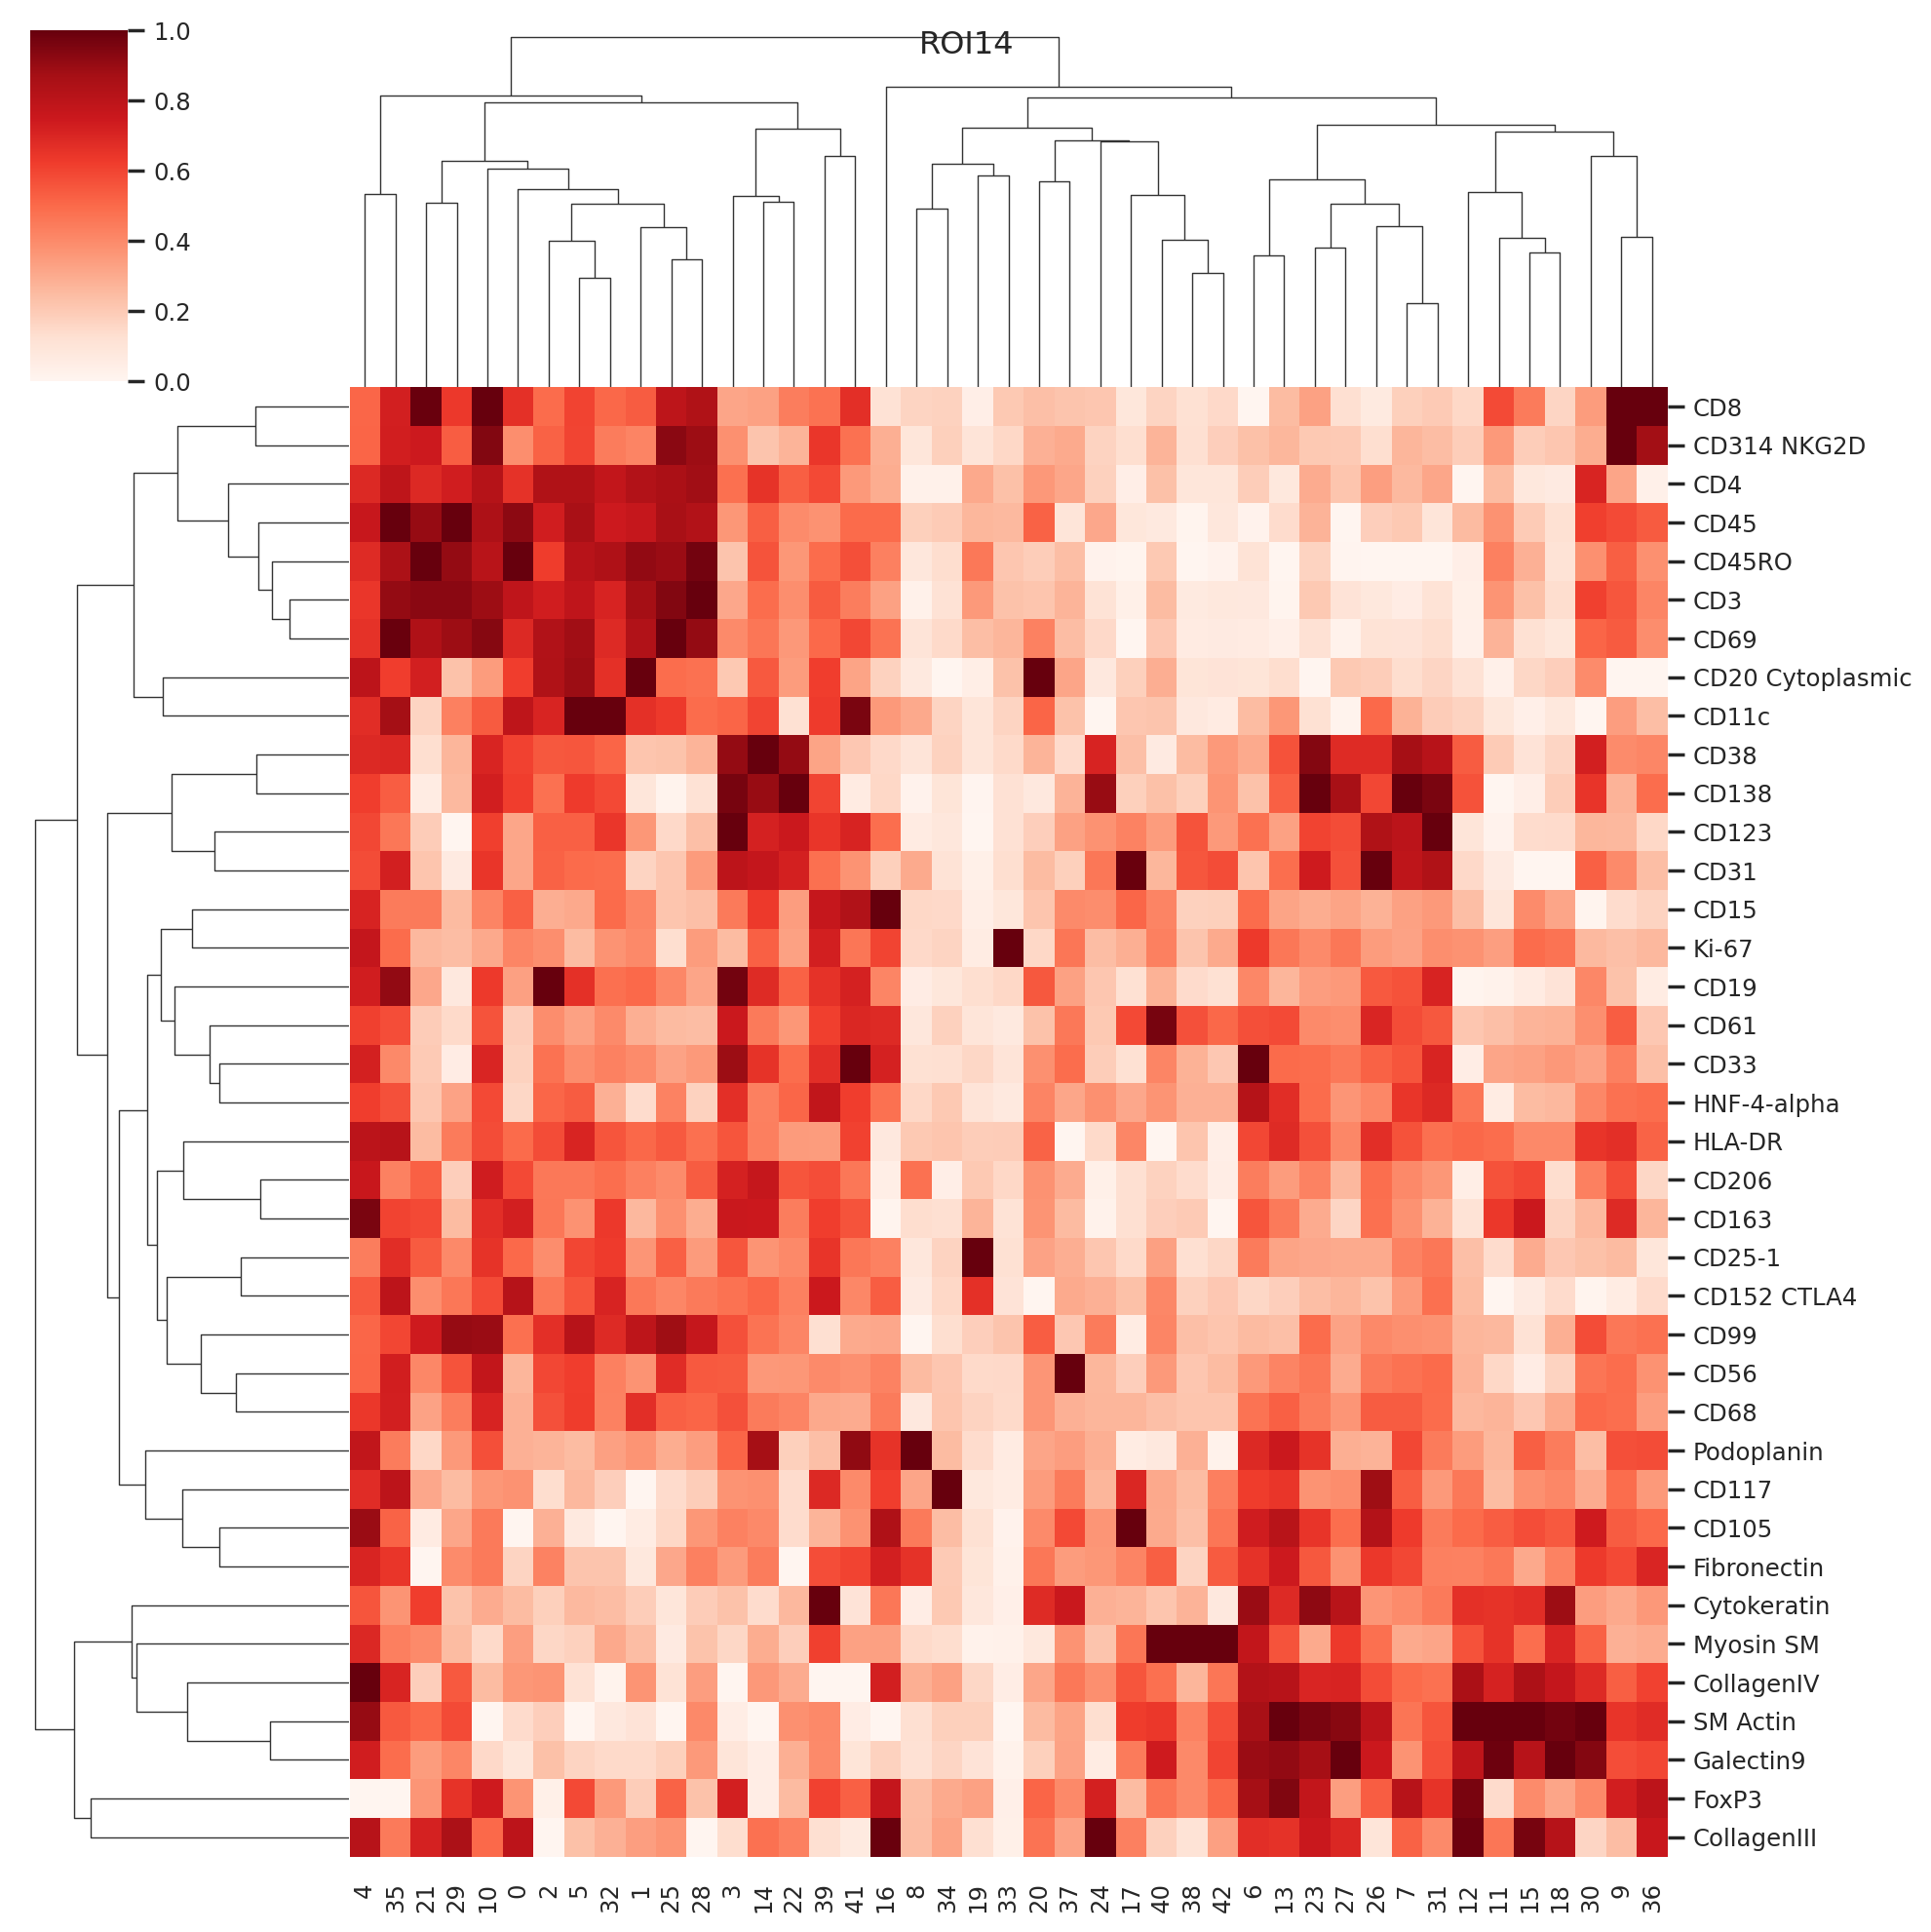

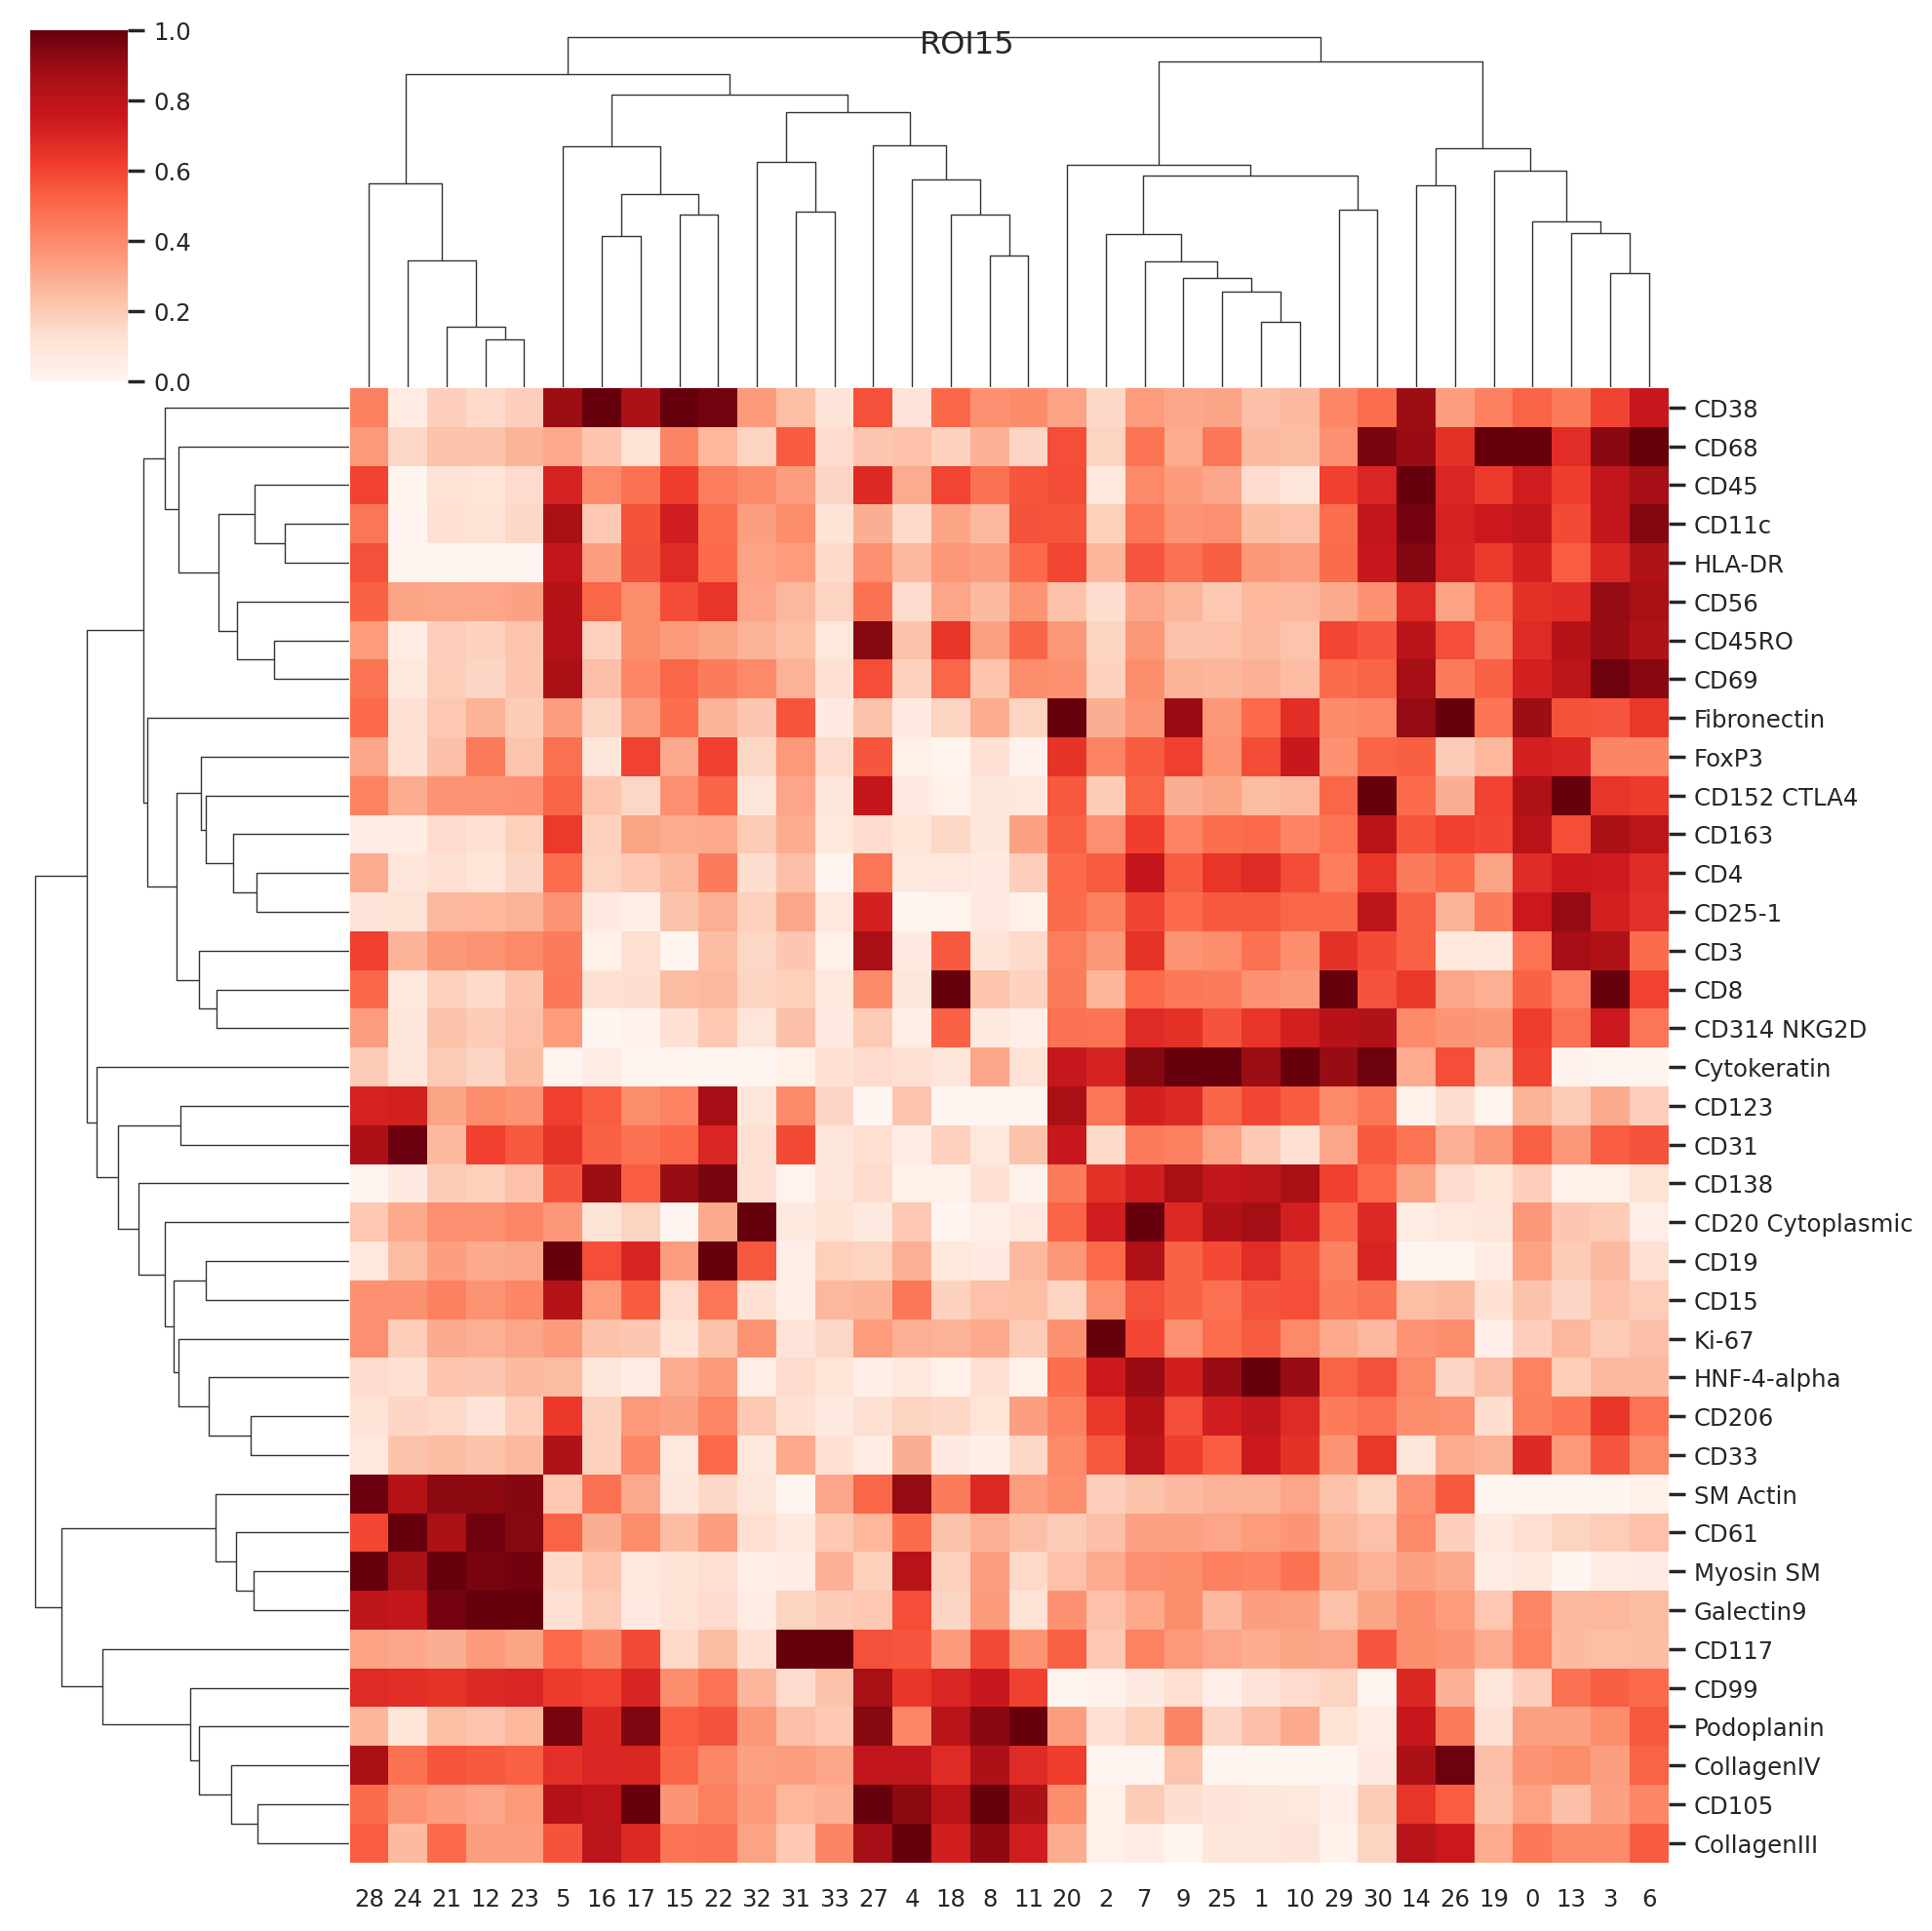

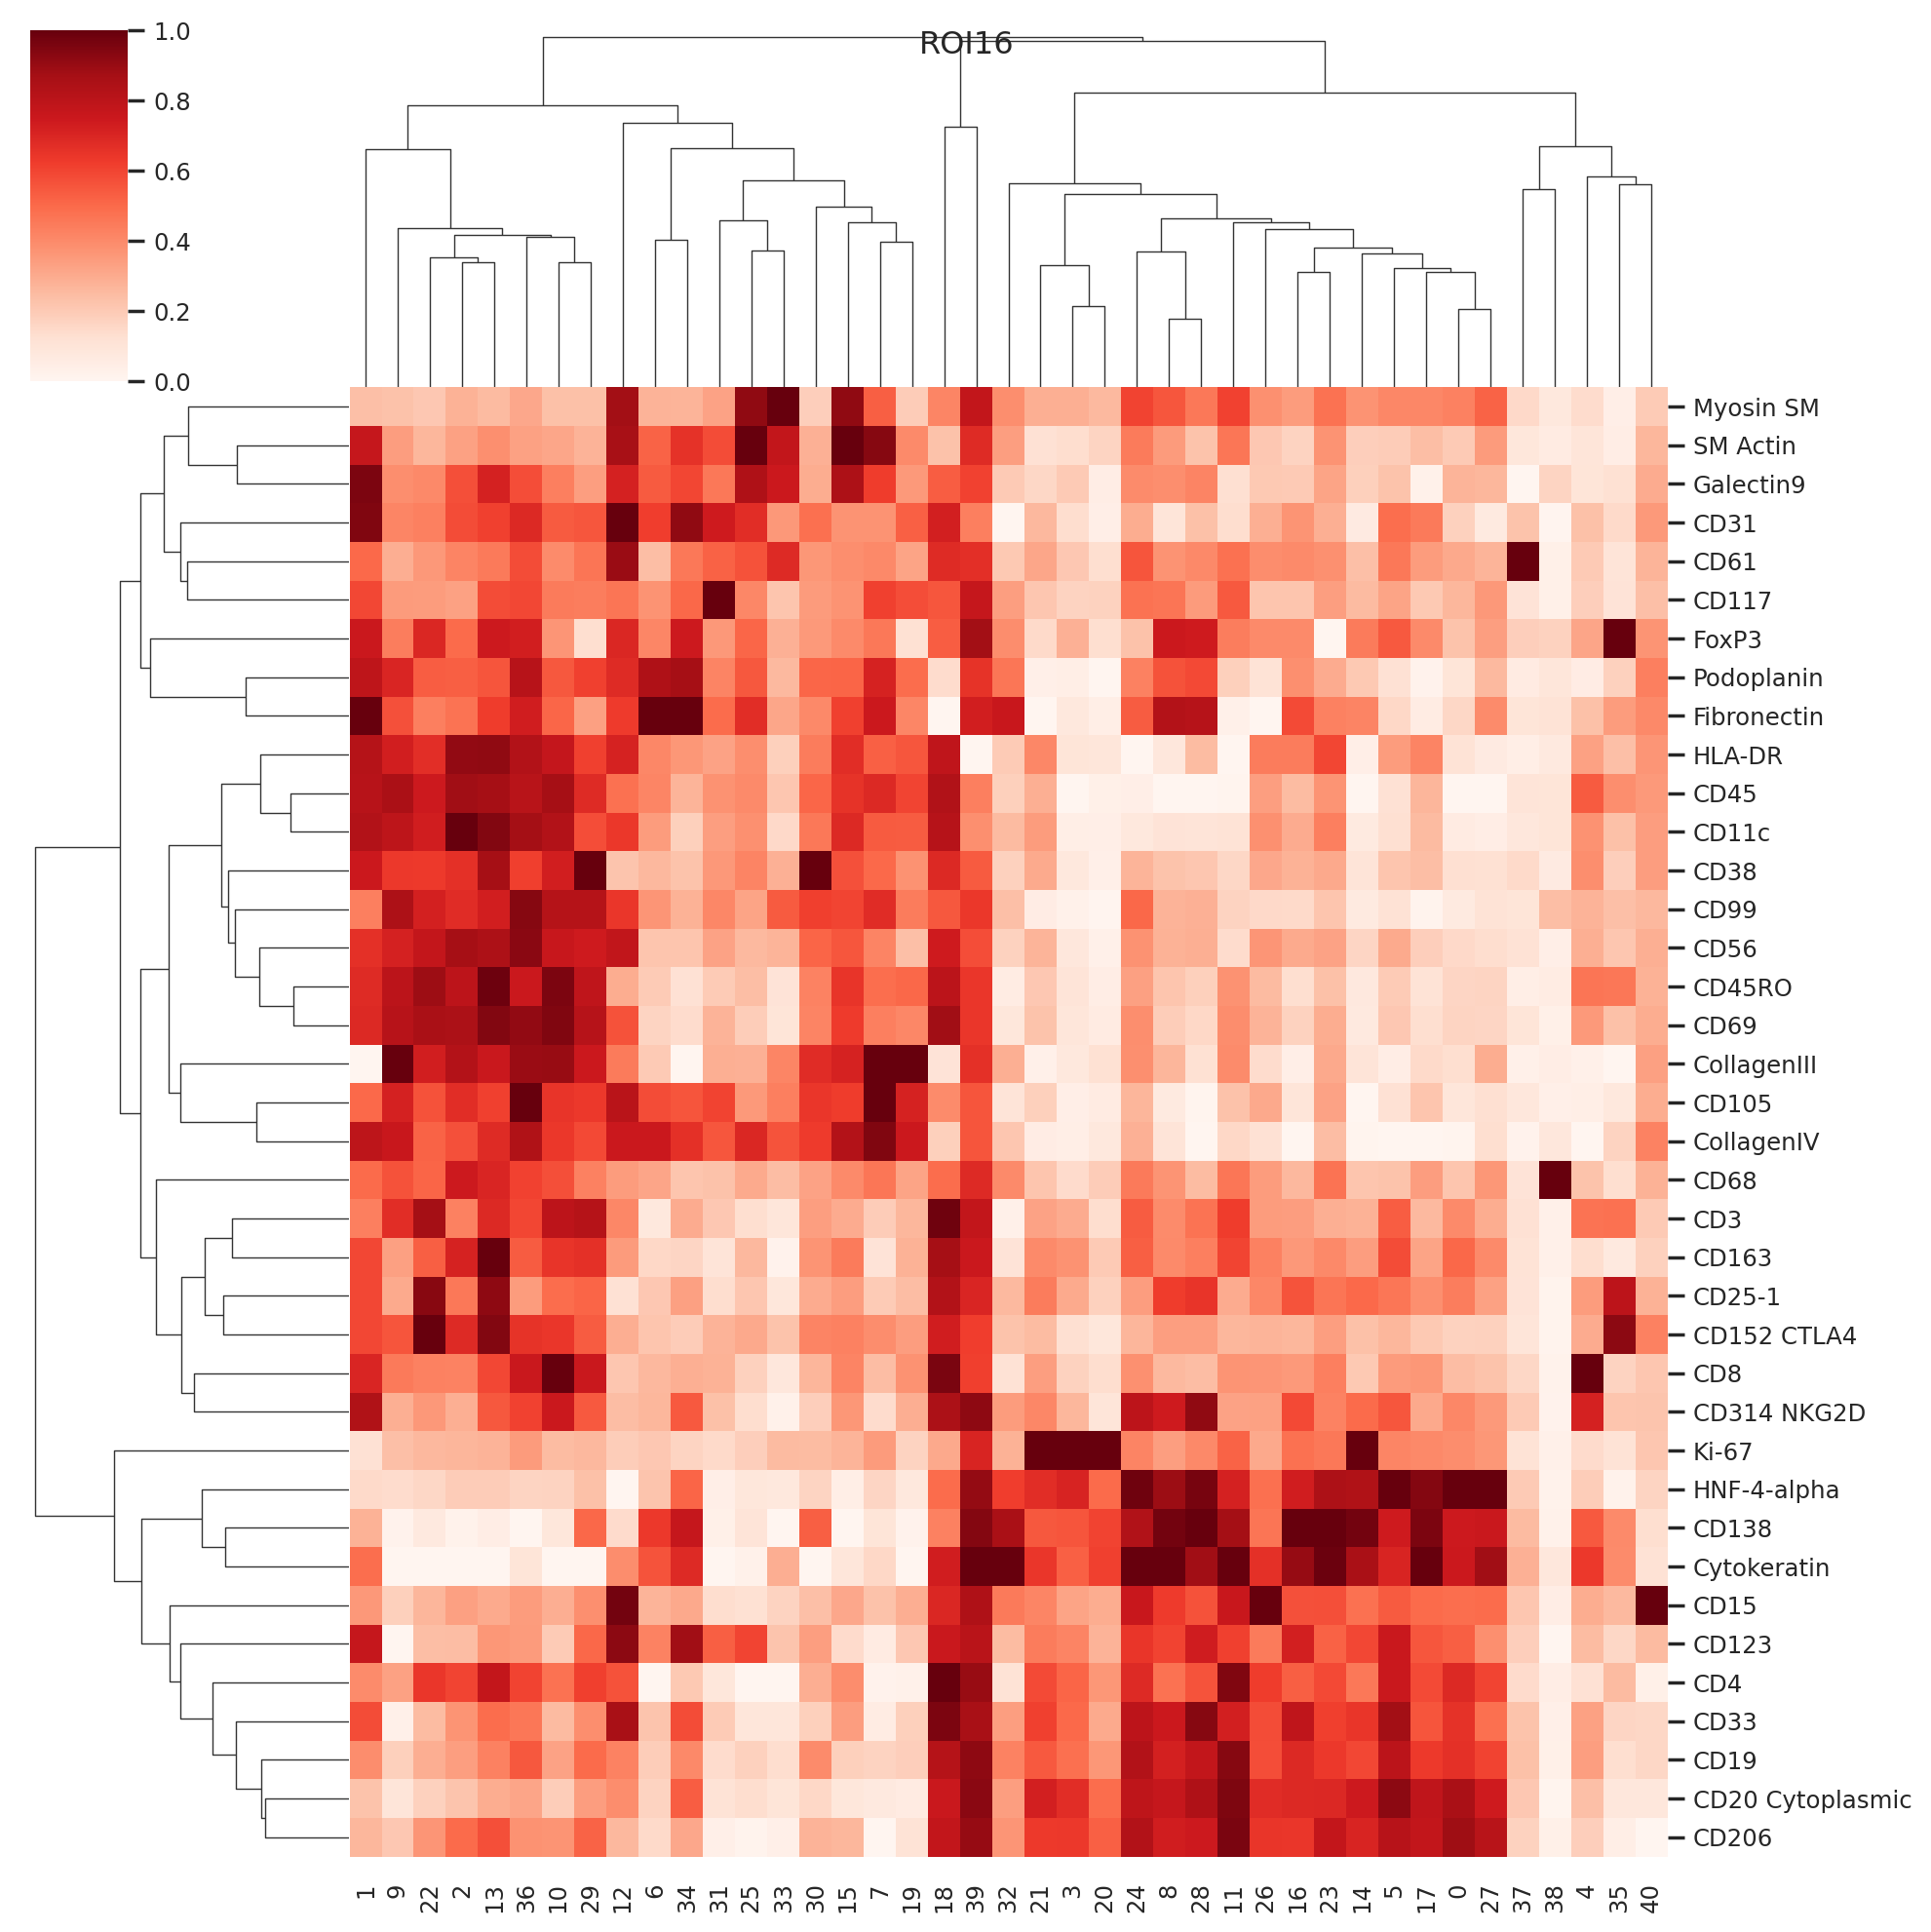

In [43]:
plotHeatmapDendro2(ROI14, 'ROI14')
plotHeatmapDendro2(ROI15, 'ROI15')
plotHeatmapDendro2(ROI16, 'ROI16')

In [44]:
# Heatmap: No standard-scale, Dendrogram on Cluster & Marker
sns.set(font_scale=0.8)
def plotHeatmapNoScale(data, name):
    plot= sns.clustermap(data.T,
                         #standard_scale=1,  # Either 0 (rows) or 1 (columns).
                          center=0,
                         cmap='coolwarm', 
                         yticklabels=True, xticklabels=True,
                         figsize=(10, 10),
                         row_cluster=True,
                         col_cluster=True)
    plot.fig.suptitle(name) 
    plot = plt.savefig('results/matrixplot_noScale_' + name + '.png', dpi=150);

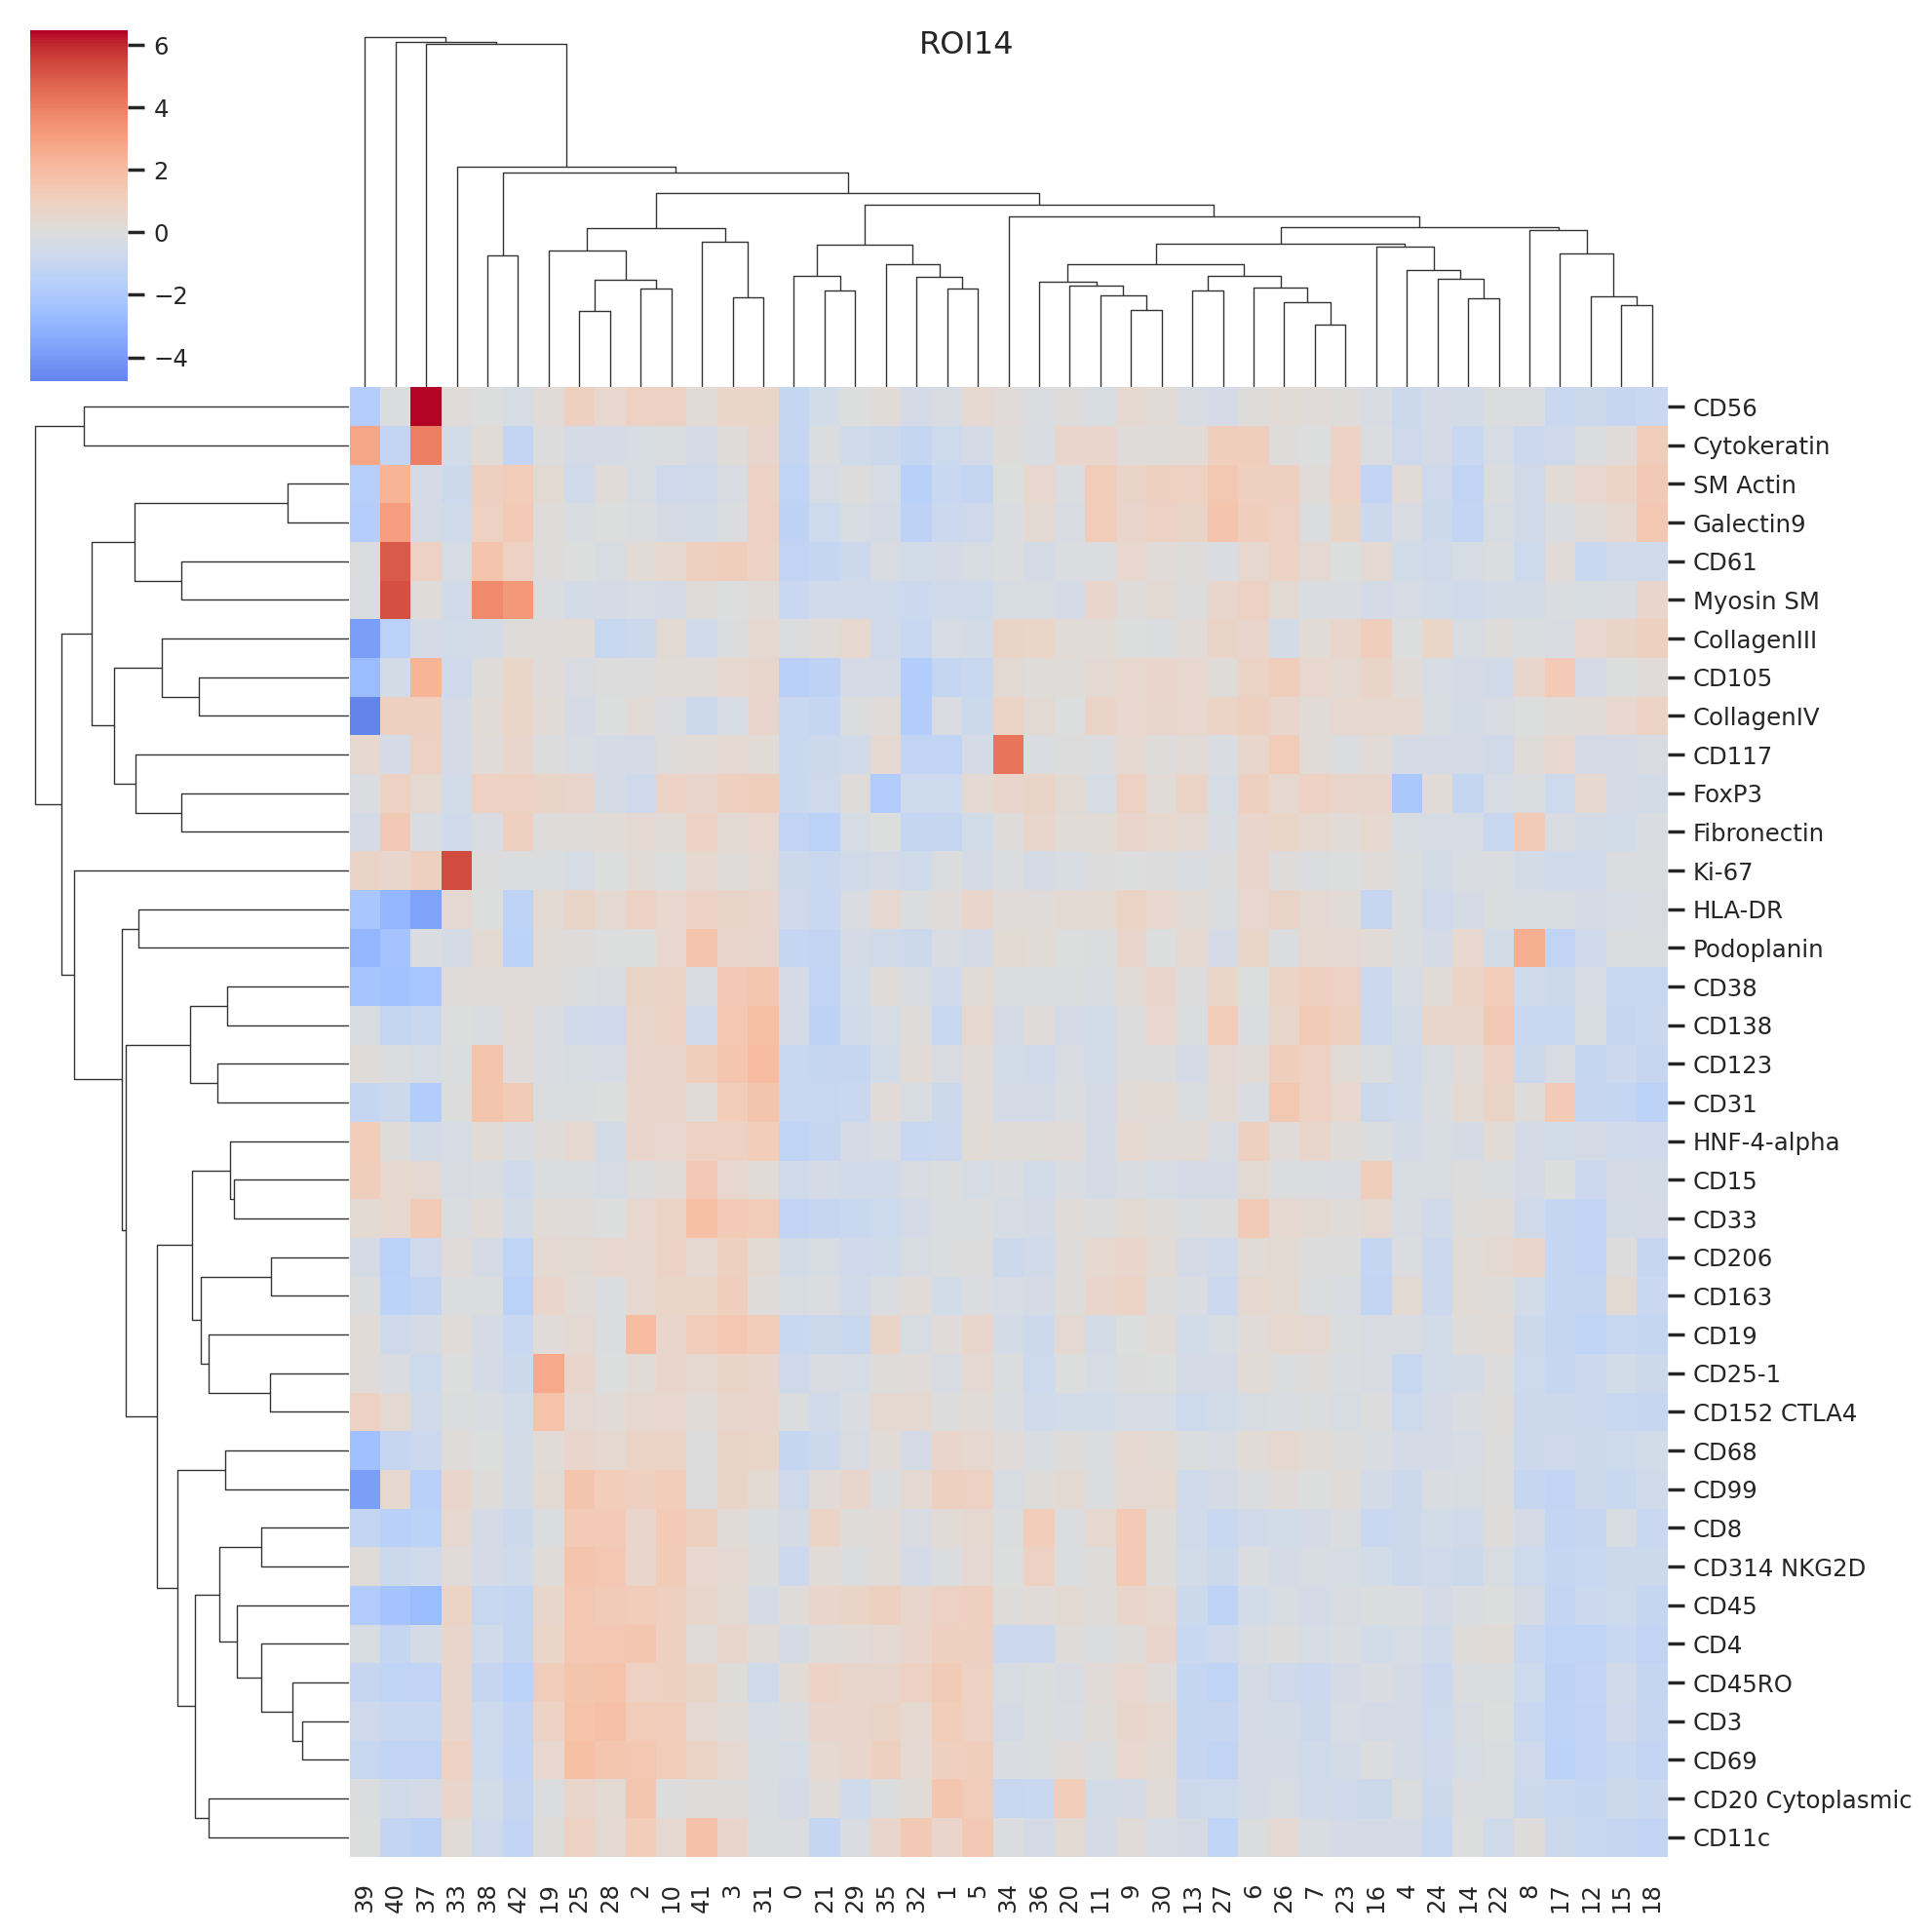

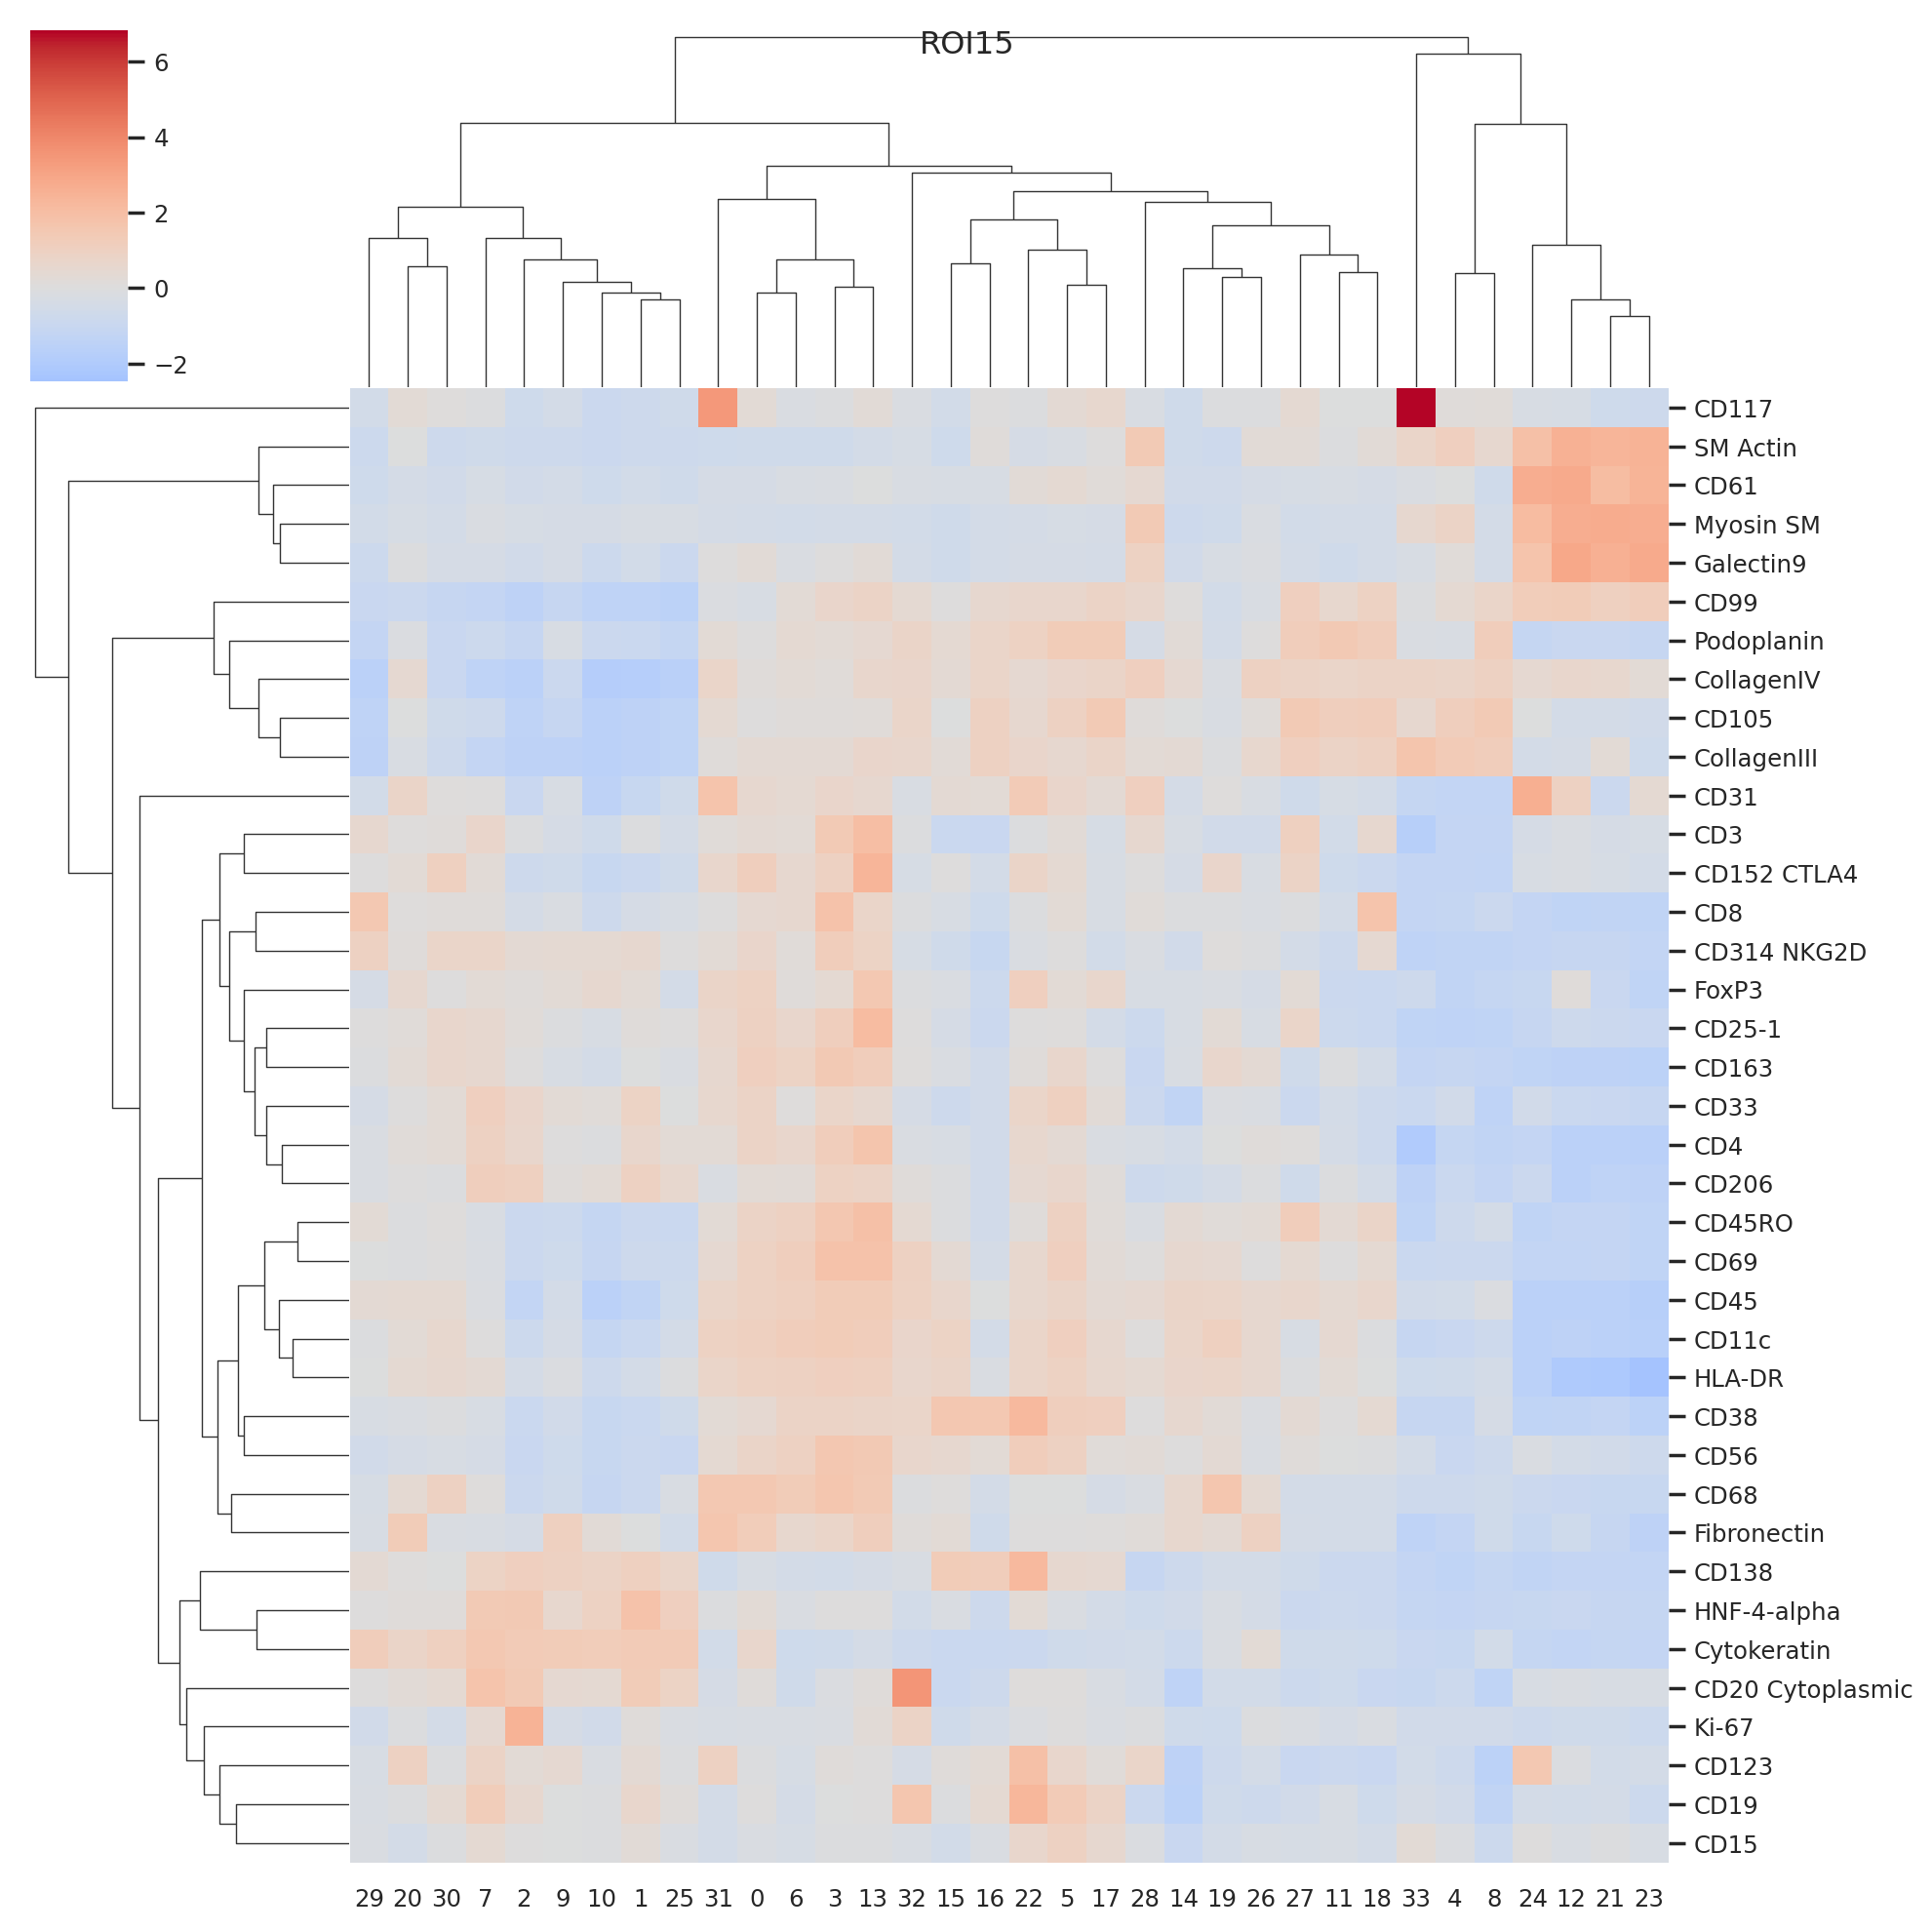

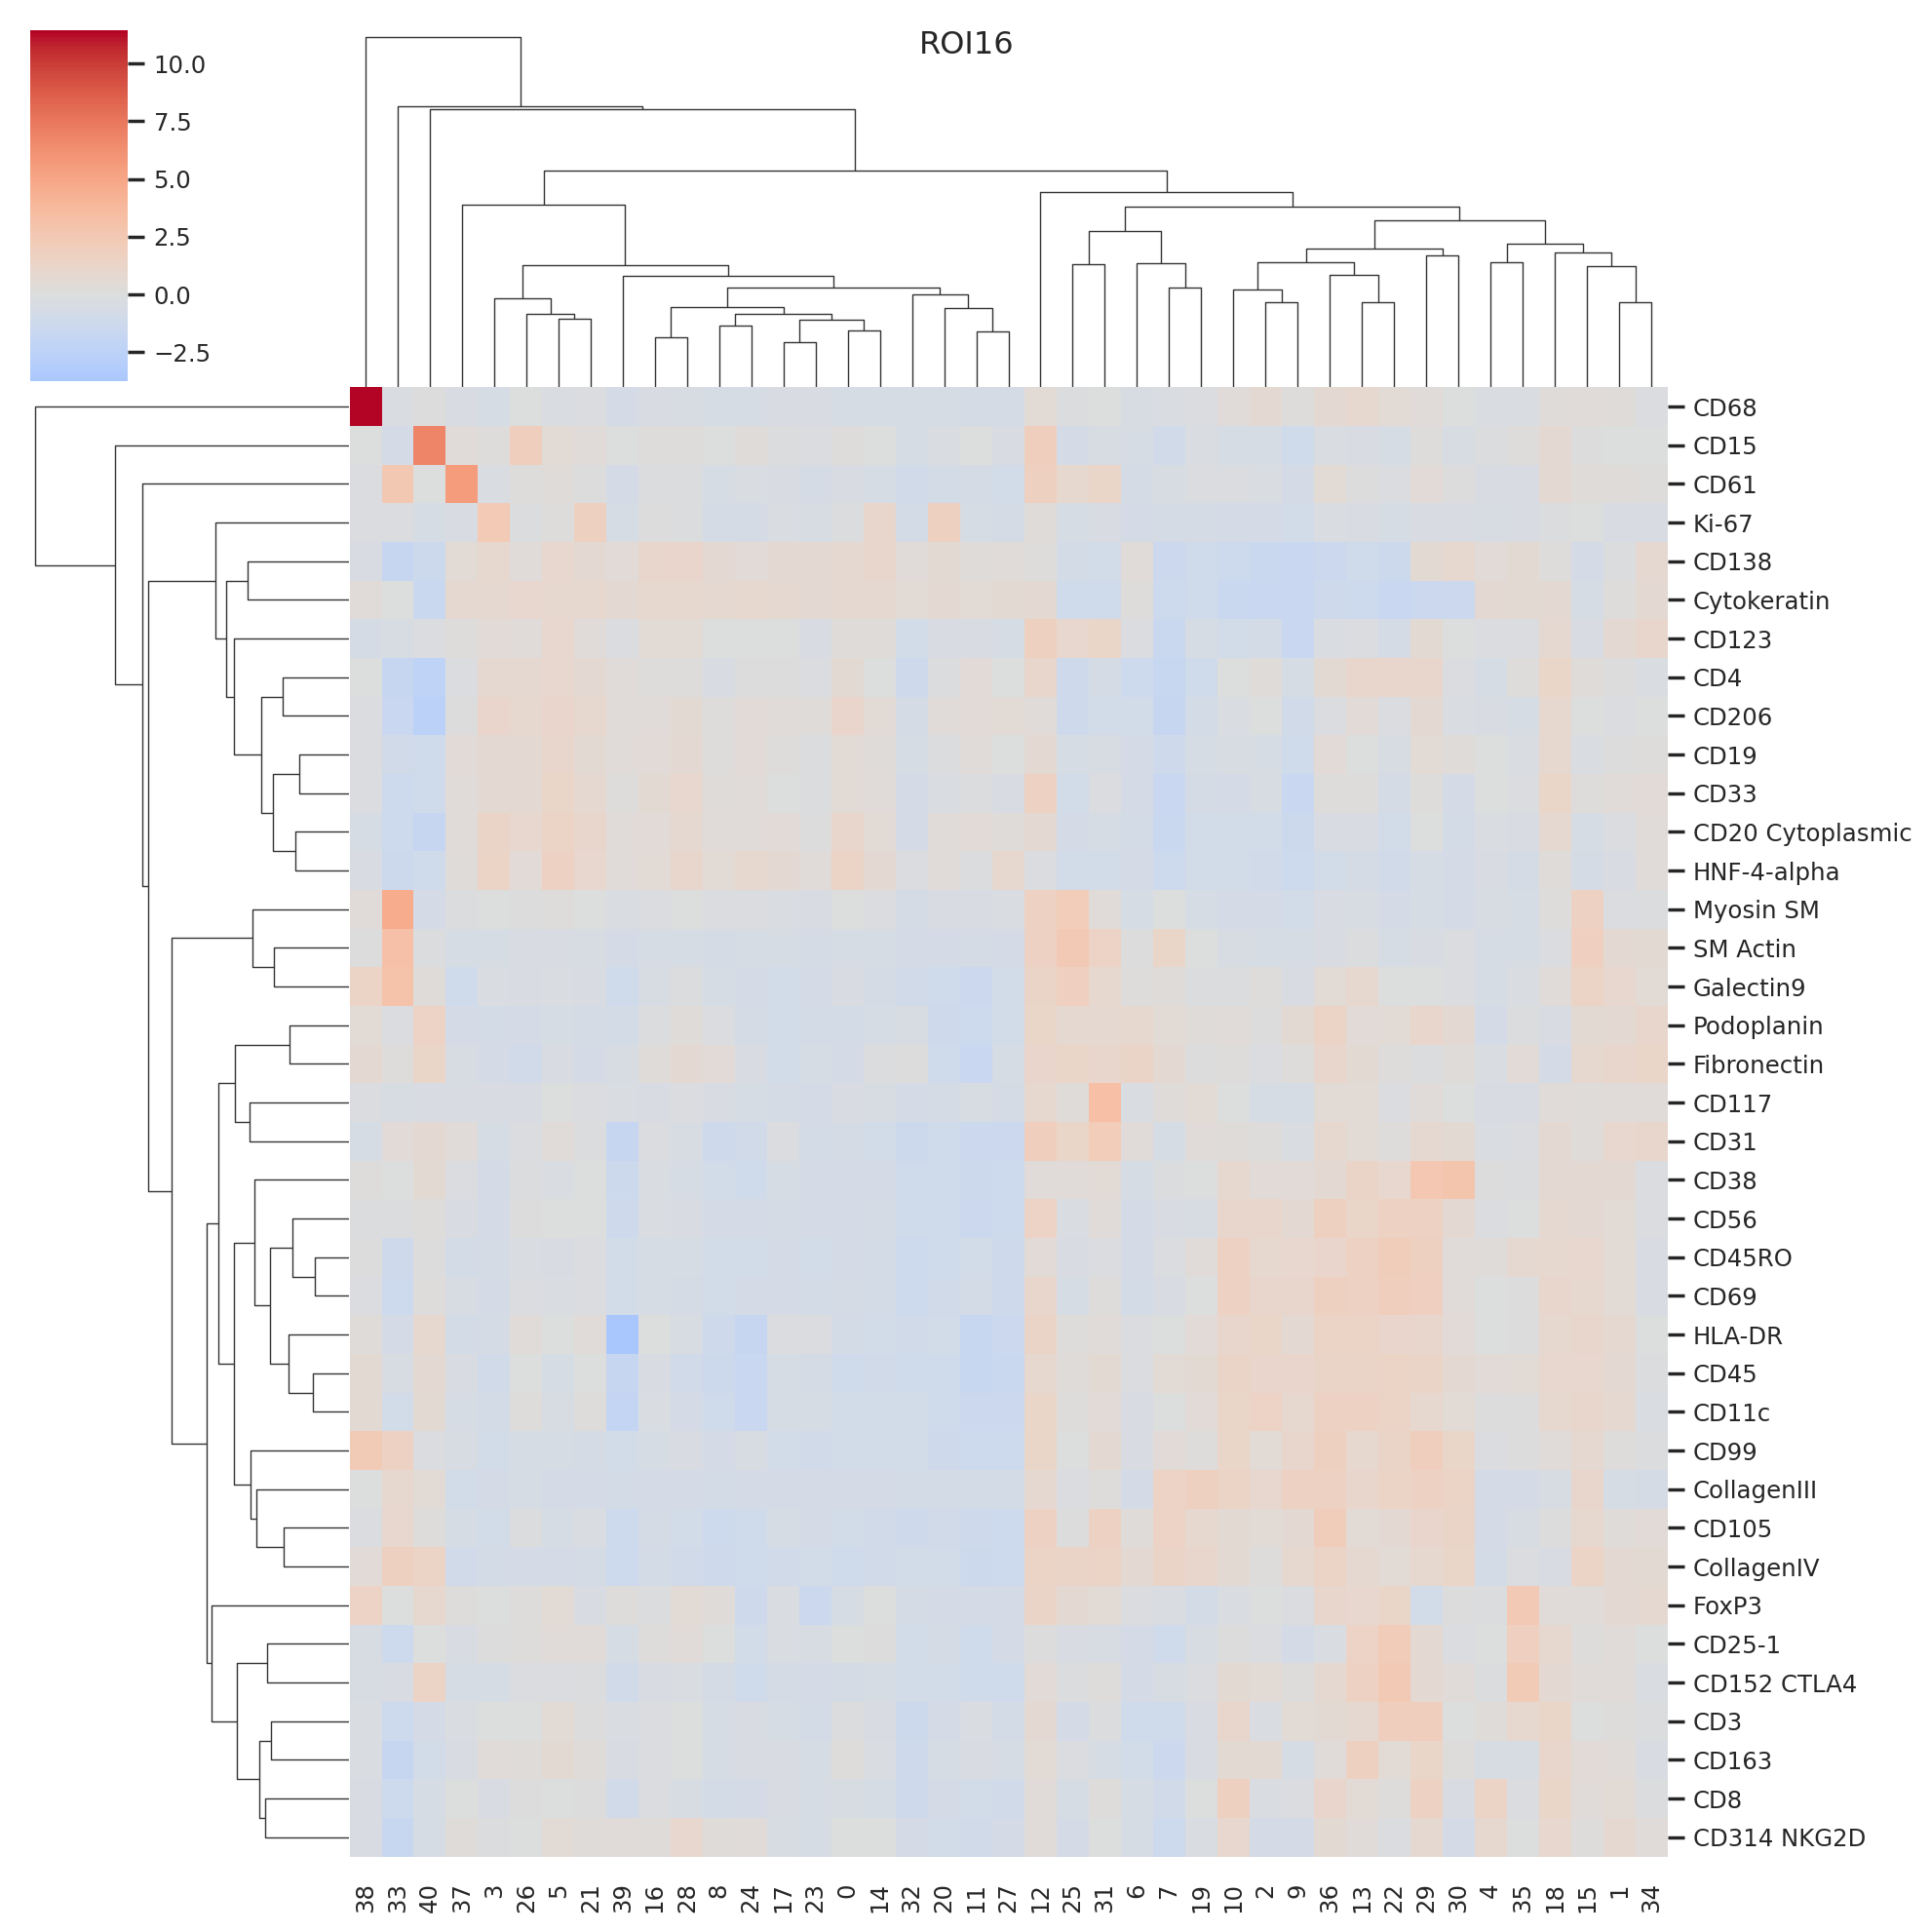

In [45]:
plotHeatmapNoScale(ROI14, 'ROI14')
plotHeatmapNoScale(ROI15, 'ROI15')
plotHeatmapNoScale(ROI16, 'ROI16')

In [46]:
def countsPerCluster(data):
    ser_counts = data.obs['leiden'].value_counts()
    ser_counts.name = 'cell counts'
    meta_leiden = pd.DataFrame(ser_counts)
    return meta_leiden

In [47]:
cellCounts = countsPerCluster(ROI14_adata)
cellCounts['cell counts'].to_list()

[293,
 275,
 256,
 238,
 229,
 225,
 222,
 216,
 207,
 207,
 200,
 197,
 196,
 192,
 187,
 187,
 181,
 180,
 156,
 148,
 145,
 142,
 109,
 109,
 108,
 108,
 106,
 102,
 99,
 98,
 96,
 91,
 85,
 84,
 76,
 67,
 59,
 50,
 49,
 44,
 43,
 35,
 34]

In [48]:
# save results in:
import os
# Make a single directory
if not os.path.exists('data'):
    os.mkdir('data')


AnnData.write(ROI14_adata, filename='data/ROI14.h5ad')
AnnData.write(ROI15_adata, filename='data/ROI15.h5ad')
AnnData.write(ROI16_adata, filename='data/ROI16.h5ad')